# Churn Analysis of Telco Customer database

### Life cycle of Machine learning Project 

<ul>
  <li>Understanding the problem statement</li>
  <li>Data collection</li>
  <li>Data checks to perform</li>
  <li>Exploratory data analysis</li>
  <li>Data Pre-processing</li>
  <li>Model trainning</li>
  <li>Choose the best model</li>
</ul>

## Problem Statement


The main objectives of this work is to identify the factors influencing churn and create a model to predict churn.

## Data cleaning with `polars`

In [12]:
import polars as pl
import os

Setting up the workdir

In [13]:
os.chdir("d://Repositories/ml-churn/")

Read initial data files

In [14]:
churn_demo  = pl.read_excel("artifacts\data_preprocessing\Telco_customer_churn_demographics.xlsx")
churn_loca  = pl.read_excel("artifacts\data_preprocessing\Telco_customer_churn_location.xlsx")
churn_serv  = pl.read_excel("artifacts\data_preprocessing\Telco_customer_churn_services.xlsx")
churn_stat  = pl.read_excel("artifacts\data_preprocessing\Telco_customer_churn_status.xlsx")

Join tables 

In [15]:
new_tab = churn_demo.join(
   churn_loca,how="left", on="Customer ID"
).join(
   churn_serv,how="left", on=["Customer ID","Count"]
).join(
   churn_stat,how="left", on=["Customer ID","Count"]
)

Inspect columns of data

In [16]:
new_tab.head(3)

shape: (3, 54)
┌─────────────┬───────┬────────┬─────┬───┬─────────────┬──────┬────────────────┬───────────────────┐
│ Customer ID ┆ Count ┆ Gender ┆ Age ┆ … ┆ Churn Score ┆ CLTV ┆ Churn Category ┆ Churn Reason      │
│ ---         ┆ ---   ┆ ---    ┆ --- ┆   ┆ ---         ┆ ---  ┆ ---            ┆ ---               │
│ str         ┆ i64   ┆ str    ┆ i64 ┆   ┆ i64         ┆ i64  ┆ str            ┆ str               │
╞═════════════╪═══════╪════════╪═════╪═══╪═════════════╪══════╪════════════════╪═══════════════════╡
│ 8779-QRDMV  ┆ 1     ┆ Male   ┆ 78  ┆ … ┆ 91          ┆ 5433 ┆ Competitor     ┆ Competitor        │
│             ┆       ┆        ┆     ┆   ┆             ┆      ┆                ┆ offered more data │
│ 7495-OOKFY  ┆ 1     ┆ Female ┆ 74  ┆ … ┆ 69          ┆ 5302 ┆ Competitor     ┆ Competitor made   │
│             ┆       ┆        ┆     ┆   ┆             ┆      ┆                ┆ better offer      │
│ 1658-BYGOY  ┆ 1     ┆ Male   ┆ 71  ┆ … ┆ 81          ┆ 3179 ┆ Competitor     ┆ Competitor made   │
│             ┆       ┆        ┆     ┆   ┆             ┆      ┆                ┆ better offer      │
└─────────────┴───────┴────────┴─────┴───┴─────────────┴──────┴────────────────┴───────────────────┘

Drop repeated variables

In [17]:
drop_variables = ["Count","Count_right","Lat Long",
                  "Quarter_right","Customer Status","Churn Label",
                  "Churn Reason","Country", "Referred a Friend","Quarter"]
drop_variables_age = ["Under 30","Senior Citizen"]

usable_tab = new_tab.drop(drop_variables)
usable_tab_no_age = usable_tab.drop(drop_variables_age)

Find null values

In [18]:
usable_tab_no_age.null_count()

shape: (1, 42)
┌─────────────┬────────┬─────┬─────────┬───┬─────────────┬─────────────┬──────┬────────────────┐
│ Customer ID ┆ Gender ┆ Age ┆ Married ┆ … ┆ Churn Value ┆ Churn Score ┆ CLTV ┆ Churn Category │
│ ---         ┆ ---    ┆ --- ┆ ---     ┆   ┆ ---         ┆ ---         ┆ ---  ┆ ---            │
│ u32         ┆ u32    ┆ u32 ┆ u32     ┆   ┆ u32         ┆ u32         ┆ u32  ┆ u32            │
╞═════════════╪════════╪═════╪═════════╪═══╪═════════════╪═════════════╪══════╪════════════════╡
│ 0           ┆ 0      ┆ 0   ┆ 0       ┆ … ┆ 0           ┆ 0           ┆ 0    ┆ 5174           │
└─────────────┴────────┴─────┴─────────┴───┴─────────────┴─────────────┴──────┴────────────────┘

Fill `None` values from `Offer` column with a new class

In [19]:
usable_tab_no_age = usable_tab_no_age.with_columns(
    pl.col("Offer").replace("None", "No Offer")
)

Fill `Null` values from `Churn Category`

In [20]:
usable_tab_no_age = usable_tab_no_age.fill_null(value="Not Churn")

Inspect different measures from data

In [21]:
usable_tab_no_age.describe()

shape: (9, 43)
┌────────────┬────────────┬────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ statistic  ┆ Customer   ┆ Gender ┆ Age       ┆ … ┆ Churn     ┆ Churn     ┆ CLTV      ┆ Churn     │
│ ---        ┆ ID         ┆ ---    ┆ ---       ┆   ┆ Value     ┆ Score     ┆ ---       ┆ Category  │
│ str        ┆ ---        ┆ str    ┆ f64       ┆   ┆ ---       ┆ ---       ┆ f64       ┆ ---       │
│            ┆ str        ┆        ┆           ┆   ┆ f64       ┆ f64       ┆           ┆ str       │
╞════════════╪════════════╪════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ count      ┆ 7043       ┆ 7043   ┆ 7043.0    ┆ … ┆ 7043.0    ┆ 7043.0    ┆ 7043.0    ┆ 7043      │
│ null_count ┆ 0          ┆ 0      ┆ 0.0       ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0         │
│ mean       ┆ null       ┆ null   ┆ 46.509726 ┆ … ┆ 0.26537   ┆ 58.50504  ┆ 4400.2957 ┆ null      │
│            ┆            ┆        ┆           ┆   ┆           ┆           ┆ 55        ┆           │
│ std        ┆ null       ┆ null   ┆ 16.750352 ┆ … ┆ 0.441561  ┆ 21.170031 ┆ 1183.0571 ┆ null      │
│            ┆            ┆        ┆           ┆   ┆           ┆           ┆ 52        ┆           │
│ min        ┆ 0002-ORFBO ┆ Female ┆ 19.0      ┆ … ┆ 0.0       ┆ 5.0       ┆ 2003.0    ┆ Attitude  │
│ 25%        ┆ null       ┆ null   ┆ 32.0      ┆ … ┆ 0.0       ┆ 40.0      ┆ 3469.0    ┆ null      │
│ 50%        ┆ null       ┆ null   ┆ 46.0      ┆ … ┆ 0.0       ┆ 61.0      ┆ 4527.0    ┆ null      │
│ 75%        ┆ null       ┆ null   ┆ 60.0      ┆ … ┆ 1.0       ┆ 76.0      ┆ 5381.0    ┆ null      │
│ max        ┆ 9995-HOTOH ┆ Male   ┆ 80.0      ┆ … ┆ 1.0       ┆ 96.0      ┆ 6500.0    ┆ Price     │
└────────────┴────────────┴────────┴───────────┴───┴───────────┴───────────┴───────────┴───────────┘

Merge Columns with same meaning in another Category, in this case `Phone service` and `Multiple lines`

In [22]:
def join_columns_phone(a, b):
    if a == 'Yes' and b == 'Yes':
        return a
    elif a == 'Yes' and b == 'No':
        return b
    elif a == 'No' and b == 'No':
        return 'No Service'
        
def join_columns_internet(a,b):
    if a == 'No' and b == 'None':
        return 'No Service'
    else:
        return b
    
usable_tab_no_age = usable_tab_no_age.with_columns(pl.struct(['Phone Service','Multiple Lines']) \
       .map_elements(lambda x: join_columns_phone(x['Phone Service'], x['Multiple Lines'])).alias('Multiple Lines'))

usable_tab_no_age.drop_in_place("Phone Service")

shape: (7_043,)
Series: 'Phone Service' [str]
[
	"No"
	"Yes"
	"Yes"
	"Yes"
	"Yes"
	"Yes"
	"Yes"
	"No"
	"Yes"
	"Yes"
	"Yes"
	"Yes"
	…
	"Yes"
	"Yes"
	"Yes"
	"Yes"
	"Yes"
	"Yes"
	"Yes"
	"No"
	"Yes"
	"Yes"
	"Yes"
	"No"
	"Yes"
]

Merge `Internet service` as a category of ``Internet Type``

In [23]:
def join_columns_internet(a,b):
    if a == 'No' and b == "None":
        return 'No Service'
    else:
        return b
    
usable_tab_no_age = usable_tab_no_age.with_columns(pl.struct(['Internet Service','Internet Type']) \
    .map_elements(lambda x: join_columns_internet(x['Internet Service'], x['Internet Type'])).alias('Internet Type'))

usable_tab_no_age.drop_in_place("Internet Service")

shape: (7_043,)
Series: 'Internet Service' [str]
[
	"Yes"
	"Yes"
	"Yes"
	"Yes"
	"Yes"
	"Yes"
	"Yes"
	"Yes"
	"Yes"
	"Yes"
	"Yes"
	"Yes"
	…
	"Yes"
	"Yes"
	"Yes"
	"Yes"
	"No"
	"Yes"
	"Yes"
	"Yes"
	"No"
	"Yes"
	"Yes"
	"Yes"
	"Yes"
]

Merge different columns with the same meaning as `Internet Type No`

In [24]:
def join_columns_all(a,b):
    if a == "No Service" and b == "No":
        return "No Service"
    else:
        return b
    
cols = ['Online Security', 'Online Backup',
       'Device Protection Plan', 'Premium Tech Support', 'Streaming TV',
       'Streaming Movies', 'Streaming Music', 'Unlimited Data']

for col in cols:

    usable_tab_no_age = usable_tab_no_age.with_columns(pl.struct(['Internet Type',col]) \
        .map_elements(lambda x: join_columns_all(x['Internet Type'], x[col])).alias(col))

    # usable_tab_no_age.drop_in_place(col)

usable_tab_no_age


shape: (7_043, 40)
┌─────────────┬────────┬─────┬─────────┬───┬─────────────┬─────────────┬──────┬─────────────────┐
│ Customer ID ┆ Gender ┆ Age ┆ Married ┆ … ┆ Churn Value ┆ Churn Score ┆ CLTV ┆ Churn Category  │
│ ---         ┆ ---    ┆ --- ┆ ---     ┆   ┆ ---         ┆ ---         ┆ ---  ┆ ---             │
│ str         ┆ str    ┆ i64 ┆ str     ┆   ┆ i64         ┆ i64         ┆ i64  ┆ str             │
╞═════════════╪════════╪═════╪═════════╪═══╪═════════════╪═════════════╪══════╪═════════════════╡
│ 8779-QRDMV  ┆ Male   ┆ 78  ┆ No      ┆ … ┆ 1           ┆ 91          ┆ 5433 ┆ Competitor      │
│ 7495-OOKFY  ┆ Female ┆ 74  ┆ Yes     ┆ … ┆ 1           ┆ 69          ┆ 5302 ┆ Competitor      │
│ 1658-BYGOY  ┆ Male   ┆ 71  ┆ No      ┆ … ┆ 1           ┆ 81          ┆ 3179 ┆ Competitor      │
│ 4598-XLKNJ  ┆ Female ┆ 78  ┆ Yes     ┆ … ┆ 1           ┆ 88          ┆ 5337 ┆ Dissatisfaction │
│ 4846-WHAFZ  ┆ Female ┆ 80  ┆ Yes     ┆ … ┆ 1           ┆ 67          ┆ 2793 ┆ Price           │
│ …           ┆ …      ┆ …   ┆ …       ┆ … ┆ …           ┆ …           ┆ …    ┆ …               │
│ 2569-WGERO  ┆ Female ┆ 30  ┆ No      ┆ … ┆ 0           ┆ 45          ┆ 5306 ┆ Not Churn       │
│ 6840-RESVB  ┆ Male   ┆ 38  ┆ Yes     ┆ … ┆ 0           ┆ 59          ┆ 2140 ┆ Not Churn       │
│ 2234-XADUH  ┆ Female ┆ 30  ┆ Yes     ┆ … ┆ 0           ┆ 71          ┆ 5560 ┆ Not Churn       │
│ 4801-JZAZL  ┆ Female ┆ 32  ┆ Yes     ┆ … ┆ 0           ┆ 59          ┆ 2793 ┆ Not Churn       │
│ 3186-AJIEK  ┆ Male   ┆ 44  ┆ No      ┆ … ┆ 0           ┆ 38          ┆ 5097 ┆ Not Churn       │
└─────────────┴────────┴─────┴─────────┴───┴─────────────┴─────────────┴──────┴─────────────────┘

`write_csv()` the usable data

In [25]:
usable_tab_no_age.write_csv("artifacts/data_preprocessing/usable_data.csv")

`reset` the kernel to unload all tables from memory

In [26]:
%reset -f

## Data Colection

### Importing data and required packages

In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import os
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

In [28]:
%pwd

'd:\\Repositories\\ml-churn'

In [29]:
os.chdir("d://Repositories/ml-churn/")

Read csv file

In [30]:
data_df = pd.read_csv("artifacts/data_preprocessing/usable_data.csv")

Printing the first 5 elements

In [31]:
data_df.head()
# Country, Referred a Friend, Phone Service

Customer ID  Gender  Age Married Dependents  Number of Dependents  \
0  8779-QRDMV    Male   78      No         No                     0   
1  7495-OOKFY  Female   74     Yes        Yes                     1   
2  1658-BYGOY    Male   71      No        Yes                     3   
3  4598-XLKNJ  Female   78     Yes        Yes                     1   
4  4846-WHAFZ  Female   80     Yes        Yes                     1   

        State         City  Zip Code   Latitude  ...  Total Charges  \
0  California  Los Angeles     90022  34.023810  ...          39.65   
1  California  Los Angeles     90063  34.044271  ...         633.30   
2  California  Los Angeles     90065  34.108833  ...        1752.55   
3  California    Inglewood     90303  33.936291  ...        2514.50   
4  California     Whittier     90602  33.972119  ...        2868.15   

   Total Refunds  Total Extra Data Charges Total Long Distance Charges  \
0           0.00                        20                        0.00   
1           0.00                         0                      390.80   
2          45.61                         0                      203.94   
3          13.43                         0                      494.00   
4           0.00                         0                      234.21   

   Total Revenue Satisfaction Score Churn Value  Churn Score  CLTV  \
0          59.65                  3           1           91  5433   
1        1024.10                  3           1           69  5302   
2        1910.88                  2           1           81  3179   
3        2995.07                  2           1           88  5337   
4        3102.36                  2           1           67  2793   

    Churn Category  
0       Competitor  
1       Competitor  
2       Competitor  
3  Dissatisfaction  
4            Price  

[5 rows x 40 columns]

## Dataset information

<ul>
  <li>CustomerID: ID asigned to customers (ID)</li>
  <li>Gender: Whether a customer is a male or female (male / female)</li>
  <li>Age: The age of clients (int)</li>
  <li>Married: Whether a customer has a partner or not (Yes / No)</li>
  <li>Dependendents: Whether a customer has dependents or not (Yes / No )</li>
  <li>Number of Dependendents: The number of dependents of clients</li>
  <li>State: State where the client reside</li>
  <li>City: City where the client reside</li>
  <li>Zip Code: Zip code of the client's houses</li>
  <li>Latitude: Latitude of the client's houses</li>
  <li>Longitude: Longitude of the client's houses</li>
  <li>Number of referals: Number of referals from a client</li>
  <li>Tenure in Months: Number of months the customer has stayed with the company (Number)</li>
  <li>Offer: The offer package that the client accepted when join</li>
  
  <li>PhoneService: Whether a customer has a phone service or not (Yes / No)</li>
  <li>Avg Monthly Long Distance Charges: Average amount expended by a client in Long distance calls</li>

  <li>MultipleLines: Whether the customer has multiple lines (Yes / No / No phone service)</li>
  <li>Internet Type: Category (DSL / Fiber optic / No)</li>
  <li>Avg Monthly GB Download: as the title describes</li>
  <li>Online Security: Whether a customer has online security or not (Yes / No / No internet service)</li>
  <li>Online Backup: Whether a customer have online backup or not (Yes / No / No internet service)</li>
  <li>Device Protection Plan: Whether a customer has device protection or not (Yes / No / No internet service)</li>
  <li>Premium Tech Support: Whether a customer has support or not (Yes / No / No internet service)</li>
  <li>Streaming TV: Whether the customer has streaming TV or not (Yes, No, No internet service)</li>
  <li>Streaming Movies: Whether the customer has streaming movies or not (Yes, No, No internet service)</li>
  <li>Streaming Music: Whether the customer has streaming music or not (Yes, No, No internet service)</li>
  <li>Unlimited Data: Whether the customer has Unlimited data or not (Yes, No, No internet service)</li>
  <li>Contract: The contract term of the customer (Month-to-month, One year, Two year)</li>
  <li>Paperless Billing: Whether the customer has paperless billing or not (Yes, No)</li>
  <li>Payment Method: The customer’s payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))</li>
  <li>Monthly Charges: The amount charged to the customer monthly</li>
  <li>Total Charges: The total amount charged to the customer</li>
  <li>Total Refunds: The total amount refund to the customer</li>
  <li>Total Extra Data Charges: The total amount of extra charges due to additional data service to the customer</li>
  <li>Total Long Distance Charges: The total amount charged to the customer in long distance calls</li>
  <li>Total Revenue: The total amount of revenue generated by a client</li>
  <li>Satisfaction Score: Satisfaction score of clients</li>
  <li>Churn value: Whether the customer churned or not (Yes|1 or No|0)</li>
  <li>Churn score: The probability of Churn</li> 
  <li>CLTV: Customer lifetime value</li>
  <li>Churn Category: Reason behind Churn</li>  
</ul>

### Data checks to perform

<ul>
  <li>Check missing values</li>
  <li>Check duplicates</li>
  <li>Check data types</li>
  <li>Check the number of uniques values in each column</li>
  <li>Check statistics of the data set</li>
</ul>

#### Check missing values

In [32]:
data_df.isna().sum()

Customer ID                          0
Gender                               0
Age                                  0
Married                              0
Dependents                           0
Number of Dependents                 0
State                                0
City                                 0
Zip Code                             0
Latitude                             0
Longitude                            0
Number of Referrals                  0
Tenure in Months                     0
Offer                                0
Avg Monthly Long Distance Charges    0
Multiple Lines                       0
Internet Type                        0
Avg Monthly GB Download              0
Online Security                      0
Online Backup                        0
Device Protection Plan               0
Premium Tech Support                 0
Streaming TV                         0
Streaming Movies                     0
Streaming Music                      0
Unlimited Data           

#### Check Duplicates

In [33]:
data_df.duplicated().sum()

0

#### Check data types

In [34]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 40 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Customer ID                        7043 non-null   object 
 1   Gender                             7043 non-null   object 
 2   Age                                7043 non-null   int64  
 3   Married                            7043 non-null   object 
 4   Dependents                         7043 non-null   object 
 5   Number of Dependents               7043 non-null   int64  
 6   State                              7043 non-null   object 
 7   City                               7043 non-null   object 
 8   Zip Code                           7043 non-null   int64  
 9   Latitude                           7043 non-null   float64
 10  Longitude                          7043 non-null   float64
 11  Number of Referrals                7043 non-null   int64

Droping `NA` values from `data_df` in case of existence

In [35]:
data_df.dropna(inplace=True)

## Data Exploration

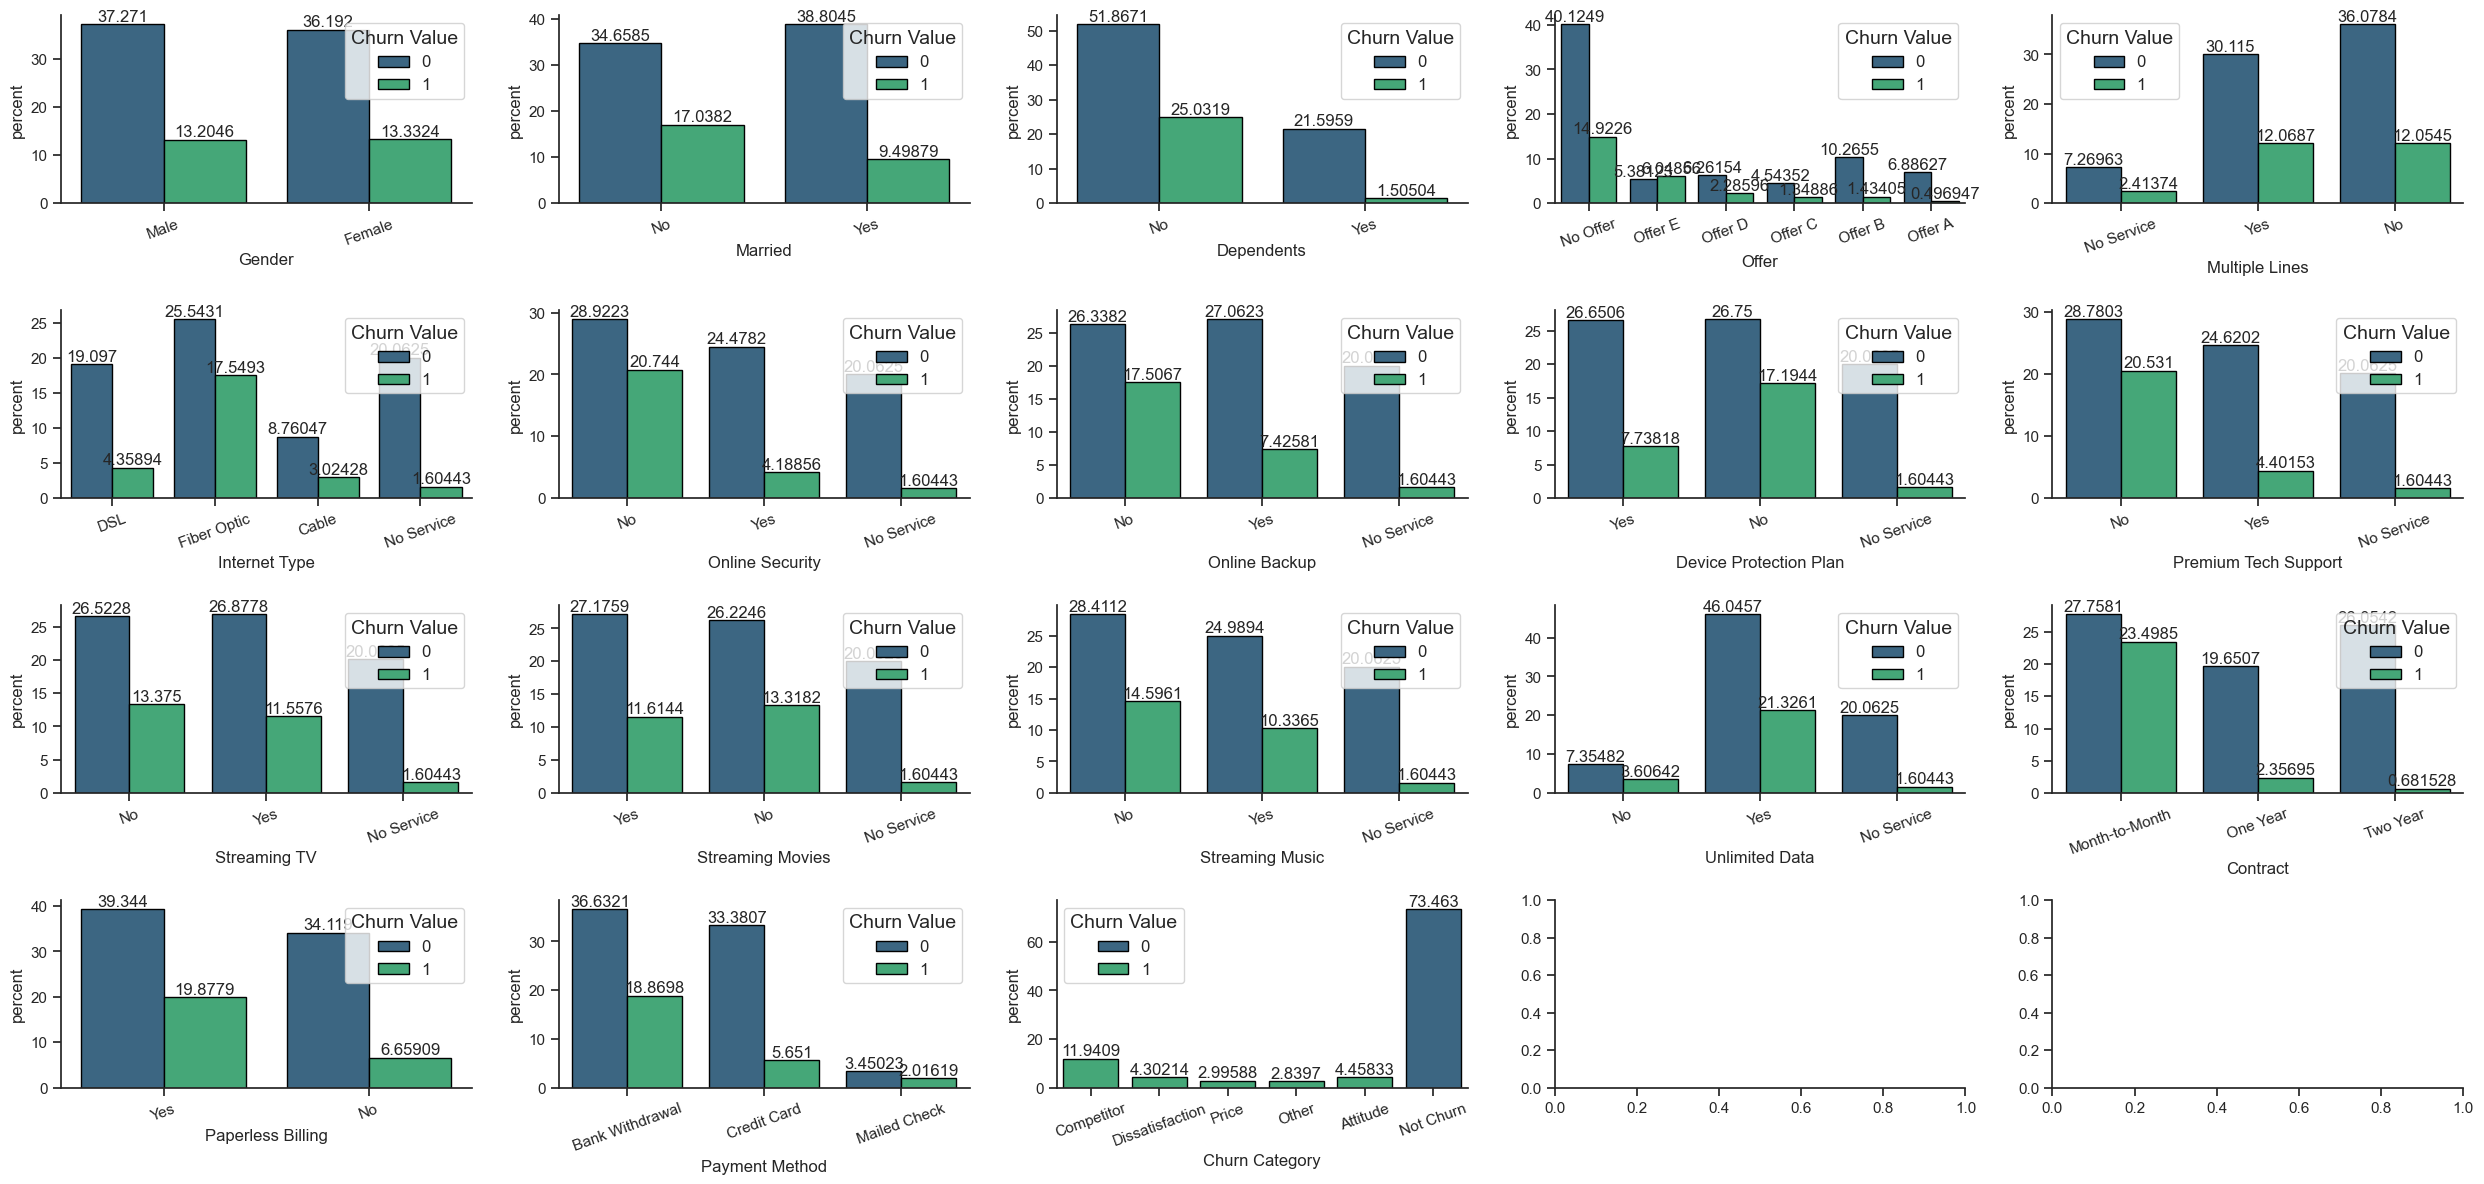

In [36]:
fig, ax = plt.subplots(4,5, figsize=(25,12))
axes = ax.ravel()

names = list(data_df.drop(columns=["Churn Value", "Customer ID",
       'Churn Score','Age', 'Number of Dependents', 'Zip Code', 'Latitude', 'Longitude',
       'Number of Referrals', 'Tenure in Months',
       'Avg Monthly Long Distance Charges', 'Avg Monthly GB Download',
       'Monthly Charge', 'Total Charges', 'Total Refunds',
       'Total Extra Data Charges', 'Total Long Distance Charges',
       'Total Revenue', 'Satisfaction Score', 'Churn Value',
       'Churn Score', 'CLTV', 'City','State']).columns)

for name, axis in zip(names,axes):
    sns.countplot(x=data_df[name], hue=data_df["Churn Value"] , palette="viridis", ax=axis, stat="percent", edgecolor = 'Black')
    axis.tick_params(axis='x', rotation=20)
    plt.setp(axis.get_legend().get_texts(), fontsize='12') # for legend text
    plt.setp(axis.get_legend().get_title(), fontsize='14') # for legend title
    for container in axis.containers:
        axis.bar_label(container)


plt.tight_layout()


- **Gender**: Do not show an effect
- **Married**: People Married Churn Less, This variable changes the distribution, you would expect to see the same distribution between categories when there is no effect.
- **Dependents**: It appears that people with dependents Churn less, it have to be studied, because there is no equal distribution, but there is a stratification inside the category.
- **Offer**: People with no offer tends to Churn More.
- **Multiple Lines**: Clients with No multiple lines Churn less.
- **Internet Service**: Among internet services, Fiber optic seems as an anomaly, people that is leaving had this service.
- **General no internet**: In general, people with no internet services shows a higher Churn rate.
- **Type of contract**: People with month-to-month contract have a Higher Churn rate, ¿maybe new clients or just jumping services?.
- **Paperless billing**: People that use paperless billing system Churns more that people who don't use it.
- **Payment method**: People that uses *bank withdrawal* and *mailed check* shows a Higher rate of Churn compared to credit card billing.

In [37]:
from scipy.signal import find_peaks
names = ['Churn Score','Age','Avg Monthly Long Distance Charges',
         'Latitude', 'Longitude','Avg Monthly GB Download',
         'Monthly Charge', 'Total Charges', 'Total Refunds',
         'Total Extra Data Charges', 'Total Long Distance Charges',
         'Total Revenue', 'Satisfaction Score','CLTV']


In [38]:
def kdeplot_with_lines(names, hue_variable):
    fig, ax = plt.subplots(4,4, figsize=(18,18))
    axes = ax.ravel()

    for name, axis in zip(names,axes):
        sns.kdeplot(x=data_df[name], hue=data_df[hue_variable] , palette="viridis", ax=axis)
        axis.tick_params(axis='x', rotation=20)
        plt.setp(axis.get_legend().get_texts(), fontsize='10') # for legend text
        plt.setp(axis.get_legend().get_title(), fontsize='12') # for legend title

        for i in range(0, np.size(axis.lines)):
            x0 = axis.lines[i].get_xdata() # Get the x data of the distribution
            y0 = axis.lines[i].get_ydata() # Get the y data of the distribution
            color = axis.lines[i].get_color() # Get the y data of the distribution

            s_y0 = find_peaks(y0)
            s_y0 = list(s_y0[0])

            for s_y in s_y0:
                axis.plot(x0[s_y] , y0[s_y], 'o', color= color)
        
        for container in axis.containers:
            axis.bar_label(container)

In [39]:
plotable_data_bool = data_df.dtypes == "object"
plotable_data = data_df.columns[plotable_data_bool].values
plotable_data

array(['Customer ID', 'Gender', 'Married', 'Dependents', 'State', 'City',
       'Offer', 'Multiple Lines', 'Internet Type', 'Online Security',
       'Online Backup', 'Device Protection Plan', 'Premium Tech Support',
       'Streaming TV', 'Streaming Movies', 'Streaming Music',
       'Unlimited Data', 'Contract', 'Paperless Billing',
       'Payment Method', 'Churn Category'], dtype=object)

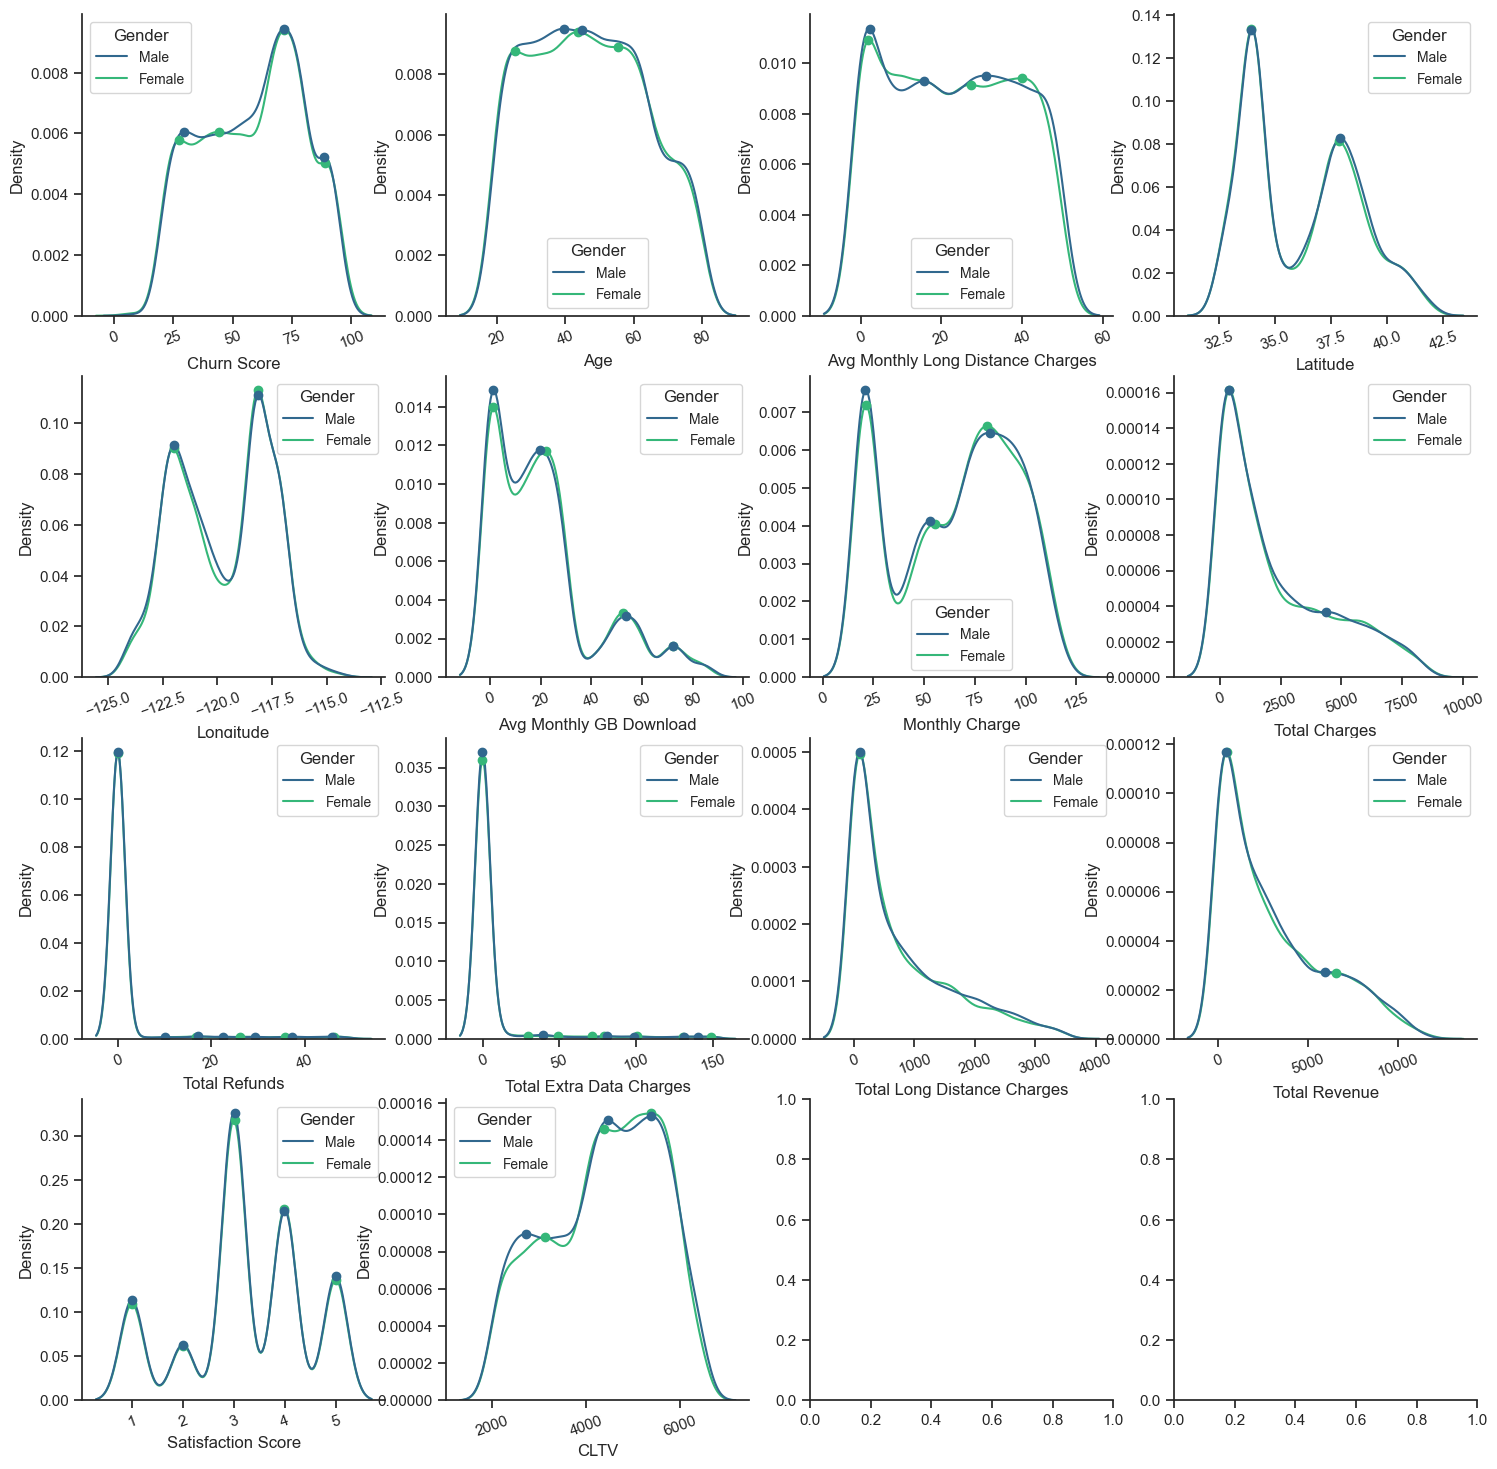

In [40]:
kdeplot_with_lines(names, 'Gender')

$\cdot$ From the plot it is observed that gender doesn't show a big impact over any of the considered variables, since main peaks are localized in the same positions for both genders and have the same density.

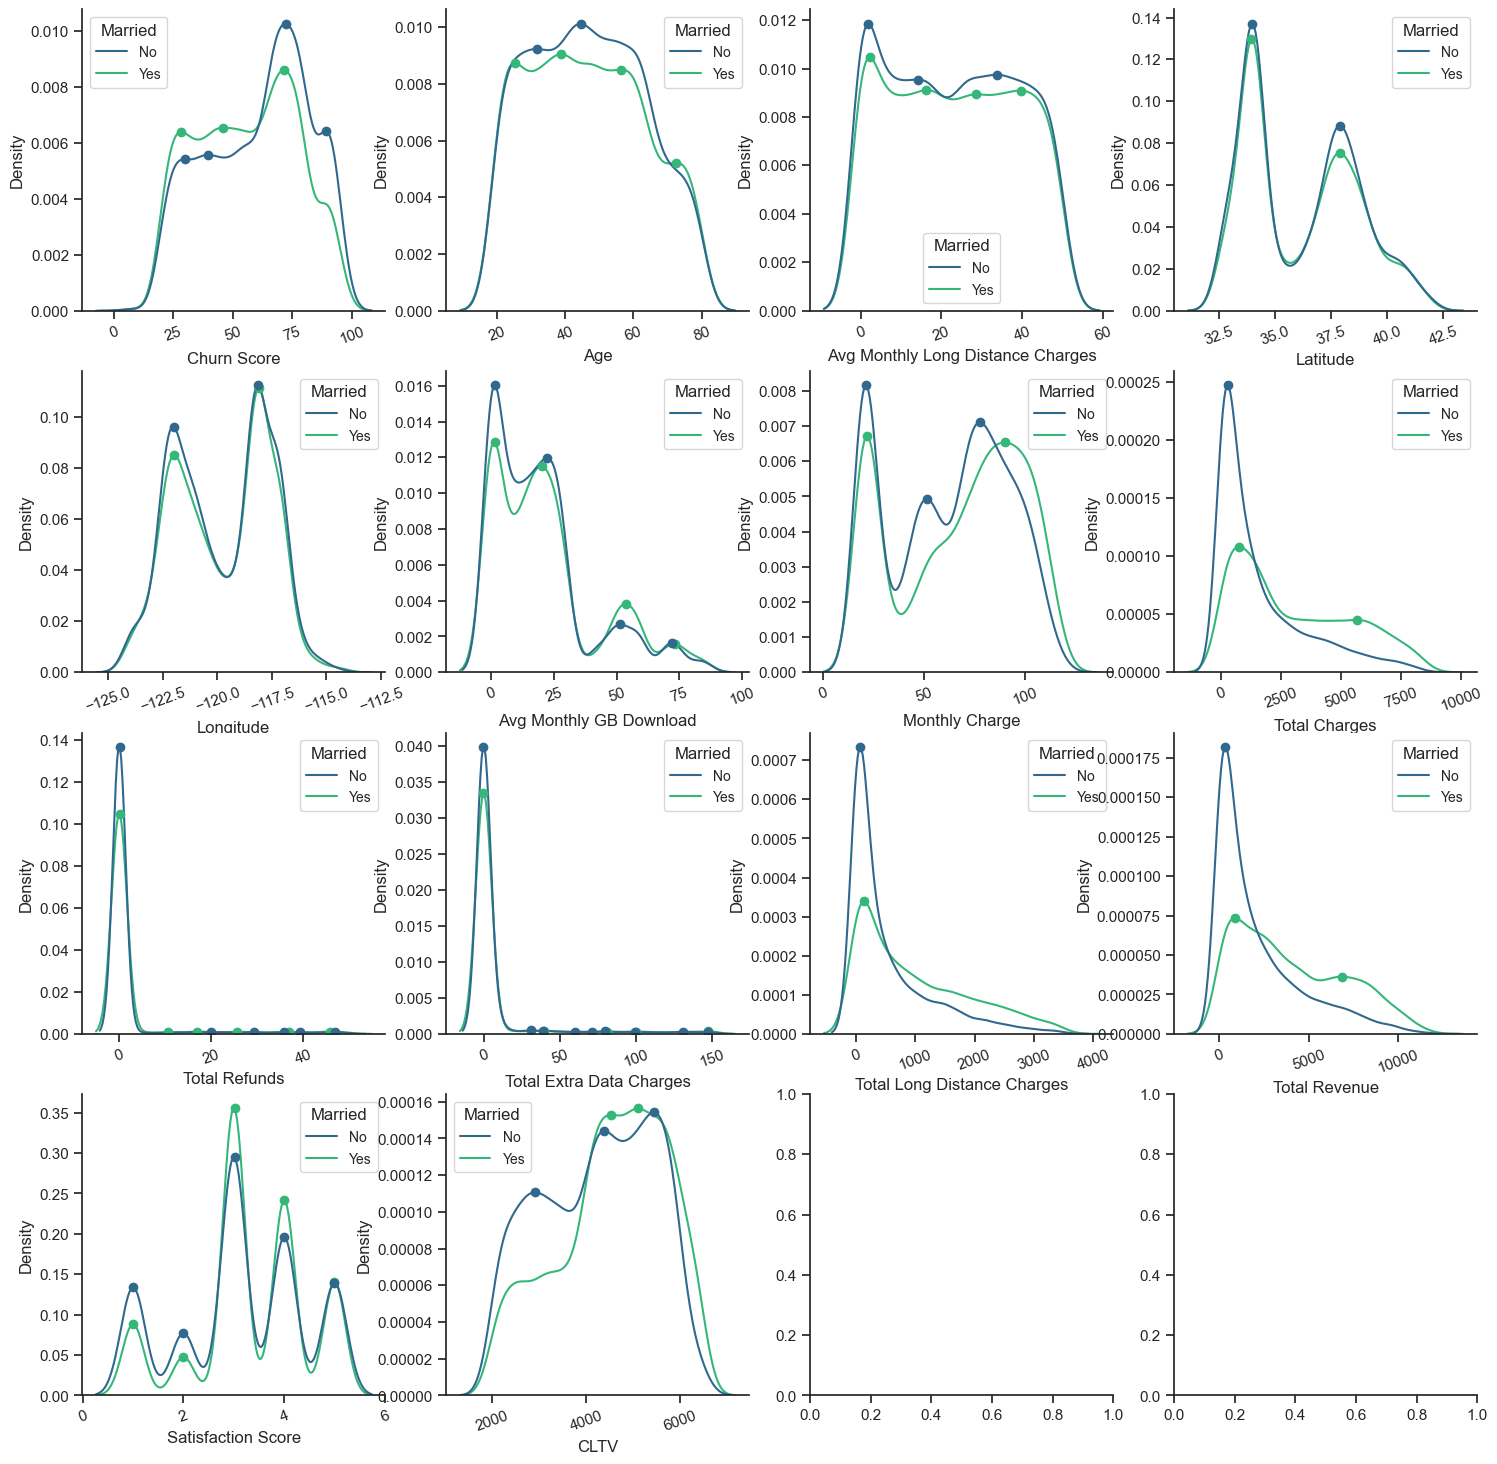

In [41]:
kdeplot_with_lines(names, 'Married')

From the plot it is observed that *Married* status shows an interaction only with *CLTV* in the lower portion of the kernel, *Married* clients shows great customer value for the company.

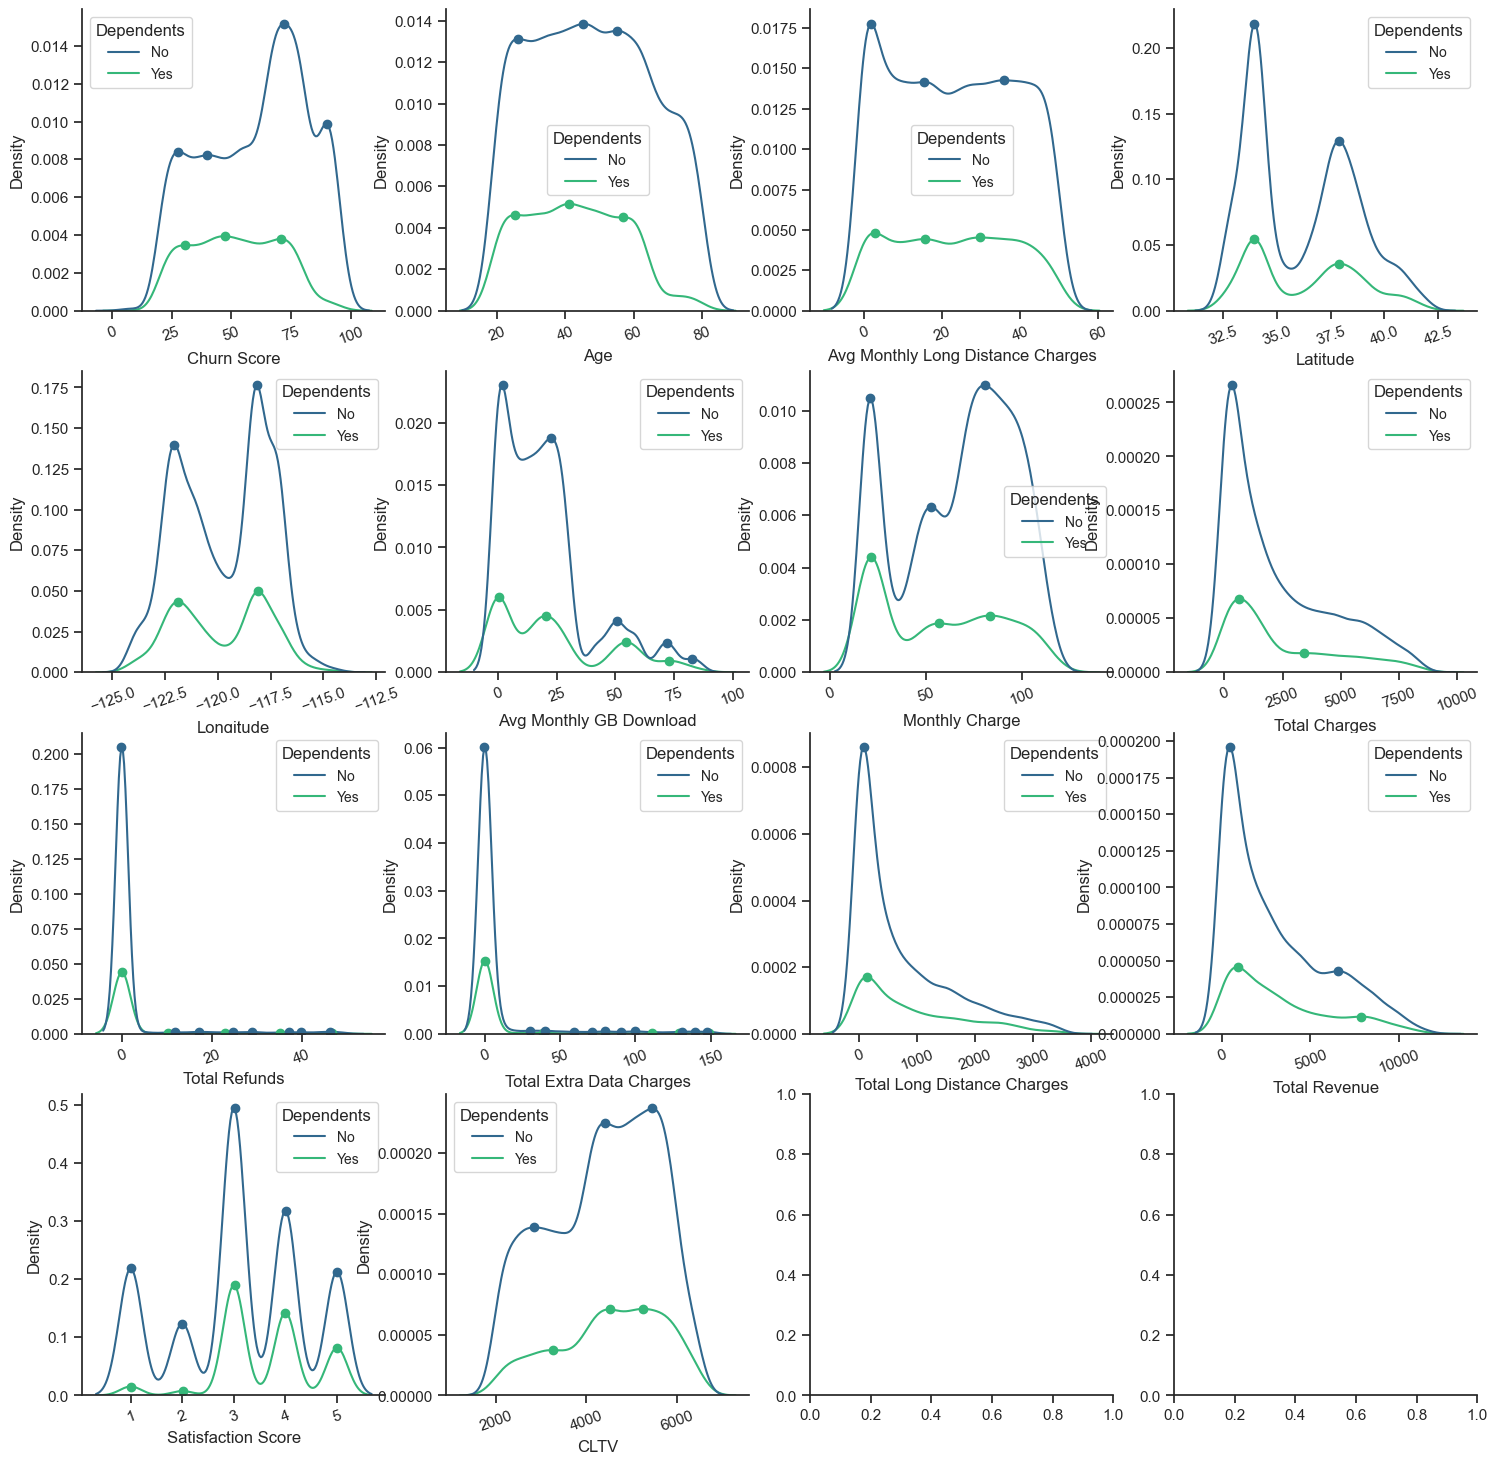

In [42]:
kdeplot_with_lines(names, 'Dependents')

*Dependents* do not show a big change in the shape of kernels, the difference reside in the amount of data points correspondent to each class, but not in the distribution itself.

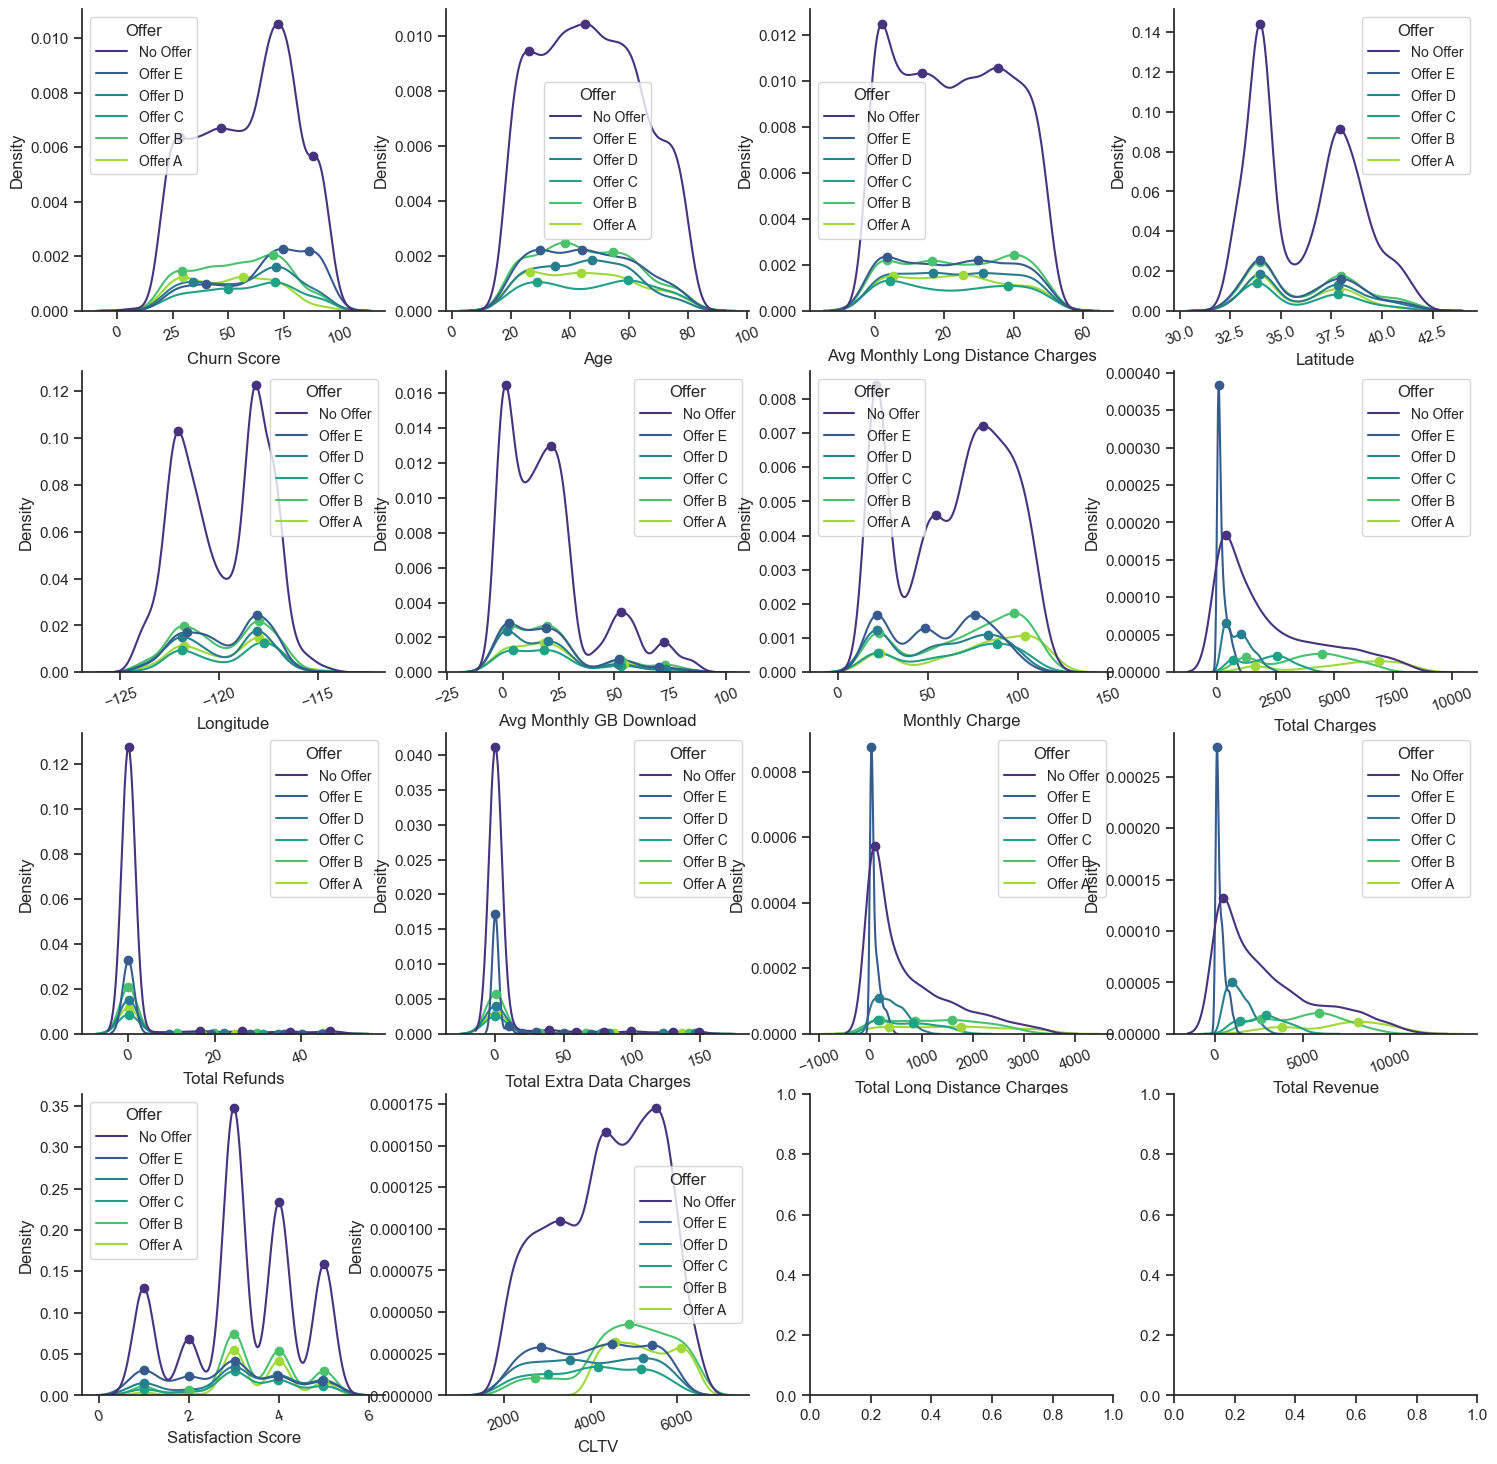

In [43]:
kdeplot_with_lines(names, 'Offer')

*Offer packages* shows interaction with: *Churn Score*, *Total Charges*, *Satisfaction Score* and *CLTV*.
Just from visual inspection, *offer packages* shows the different results of different packages strategies with clients. Clustering analisis can probe for 'who' are effective those packages.

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.


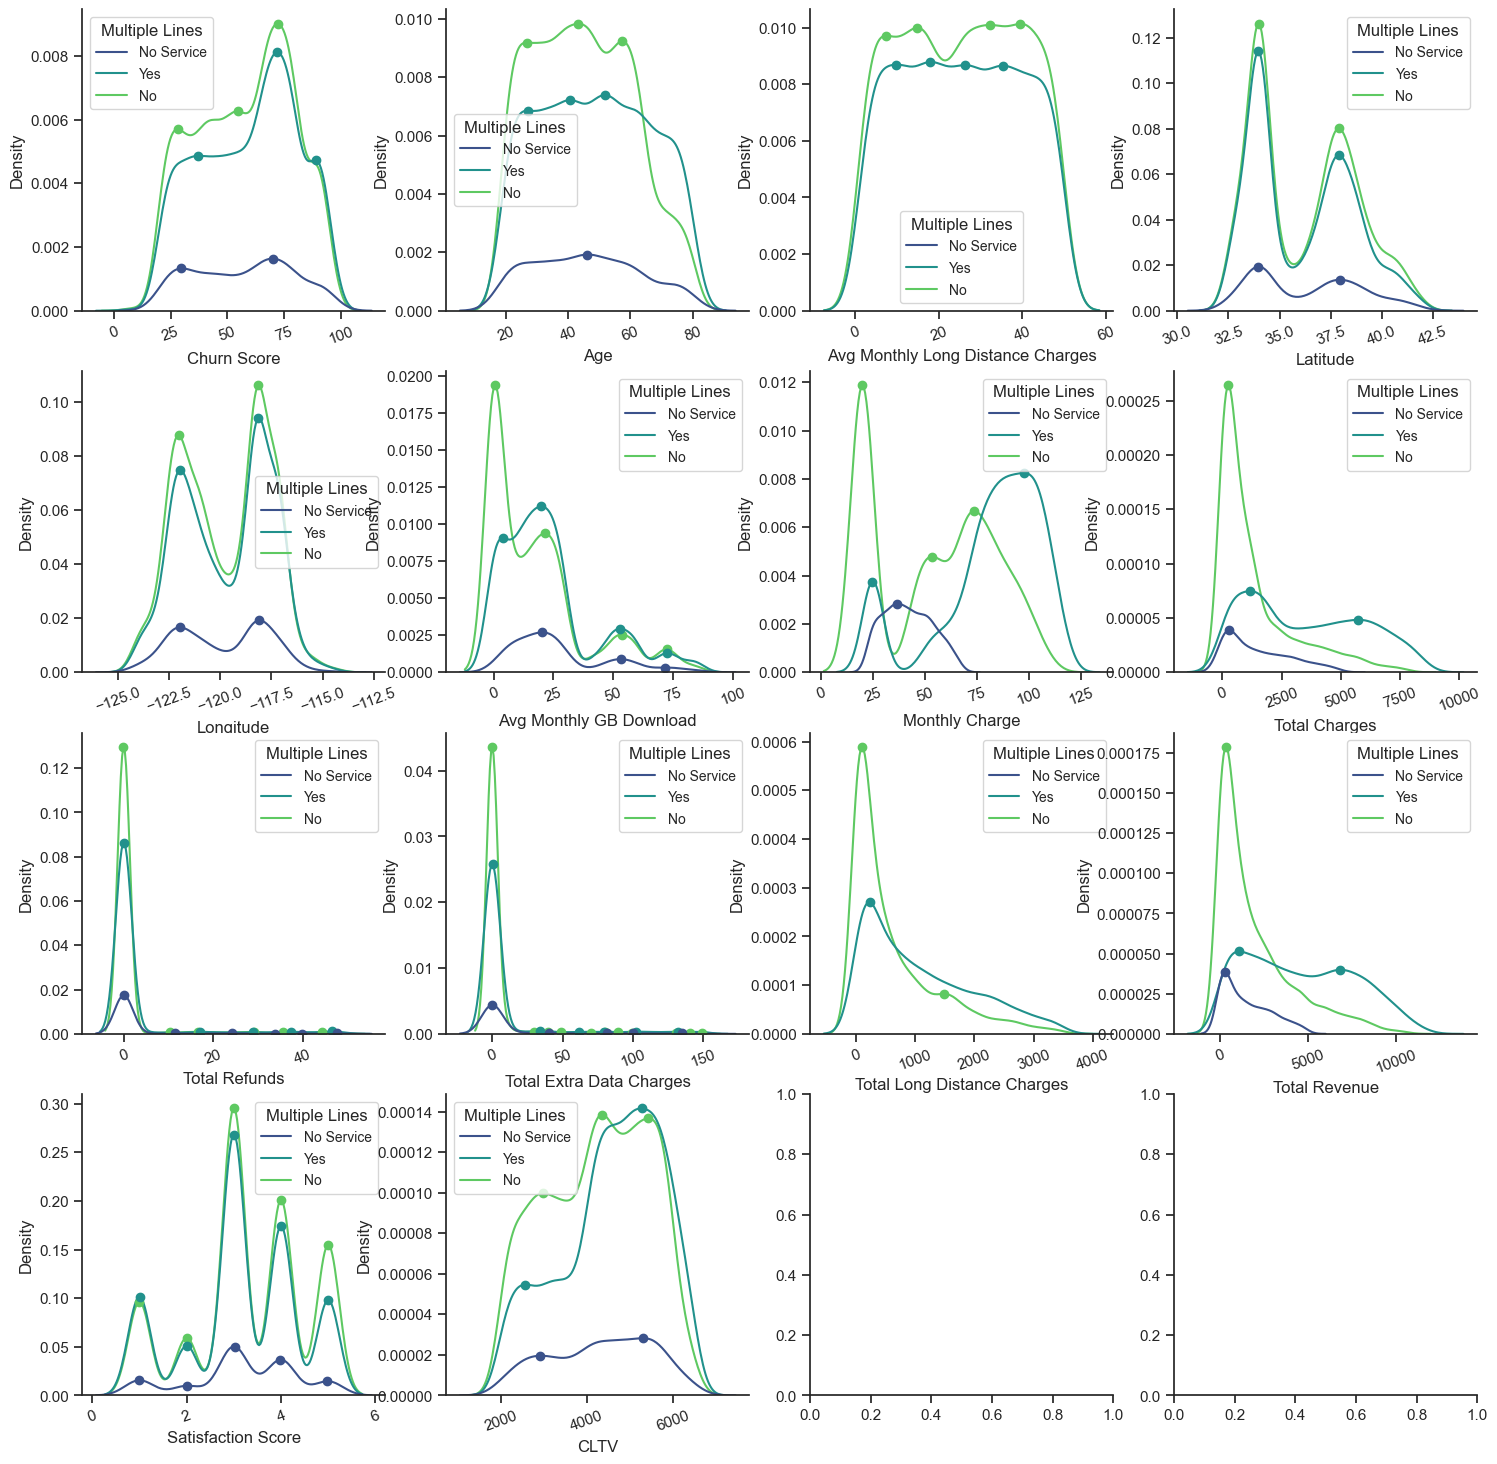

In [44]:
kdeplot_with_lines(names, 'Multiple Lines')
# 'Multiple Lines', 'Internet Type', 'Contract', 'Paperless Billing',
    #    'Payment Method'

*Phone Service* or *Multiple Lines*: From visual inspection it shows relation with *Monthly Charges*, *Total Charges*, and *Total Revenue*. 
- Clients with *Multiple Lines* Shows a concentration of Monthly charges around 85, there are some points that lies outside this distribution, ¿can they be another group? ¿or are they noise?, got to inspect more.
- Clients with no service have a monthly charge centered around 35 with no outliers.
- Clients with just one phone shows two main kernels, there should be two types of people with one phone.

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.


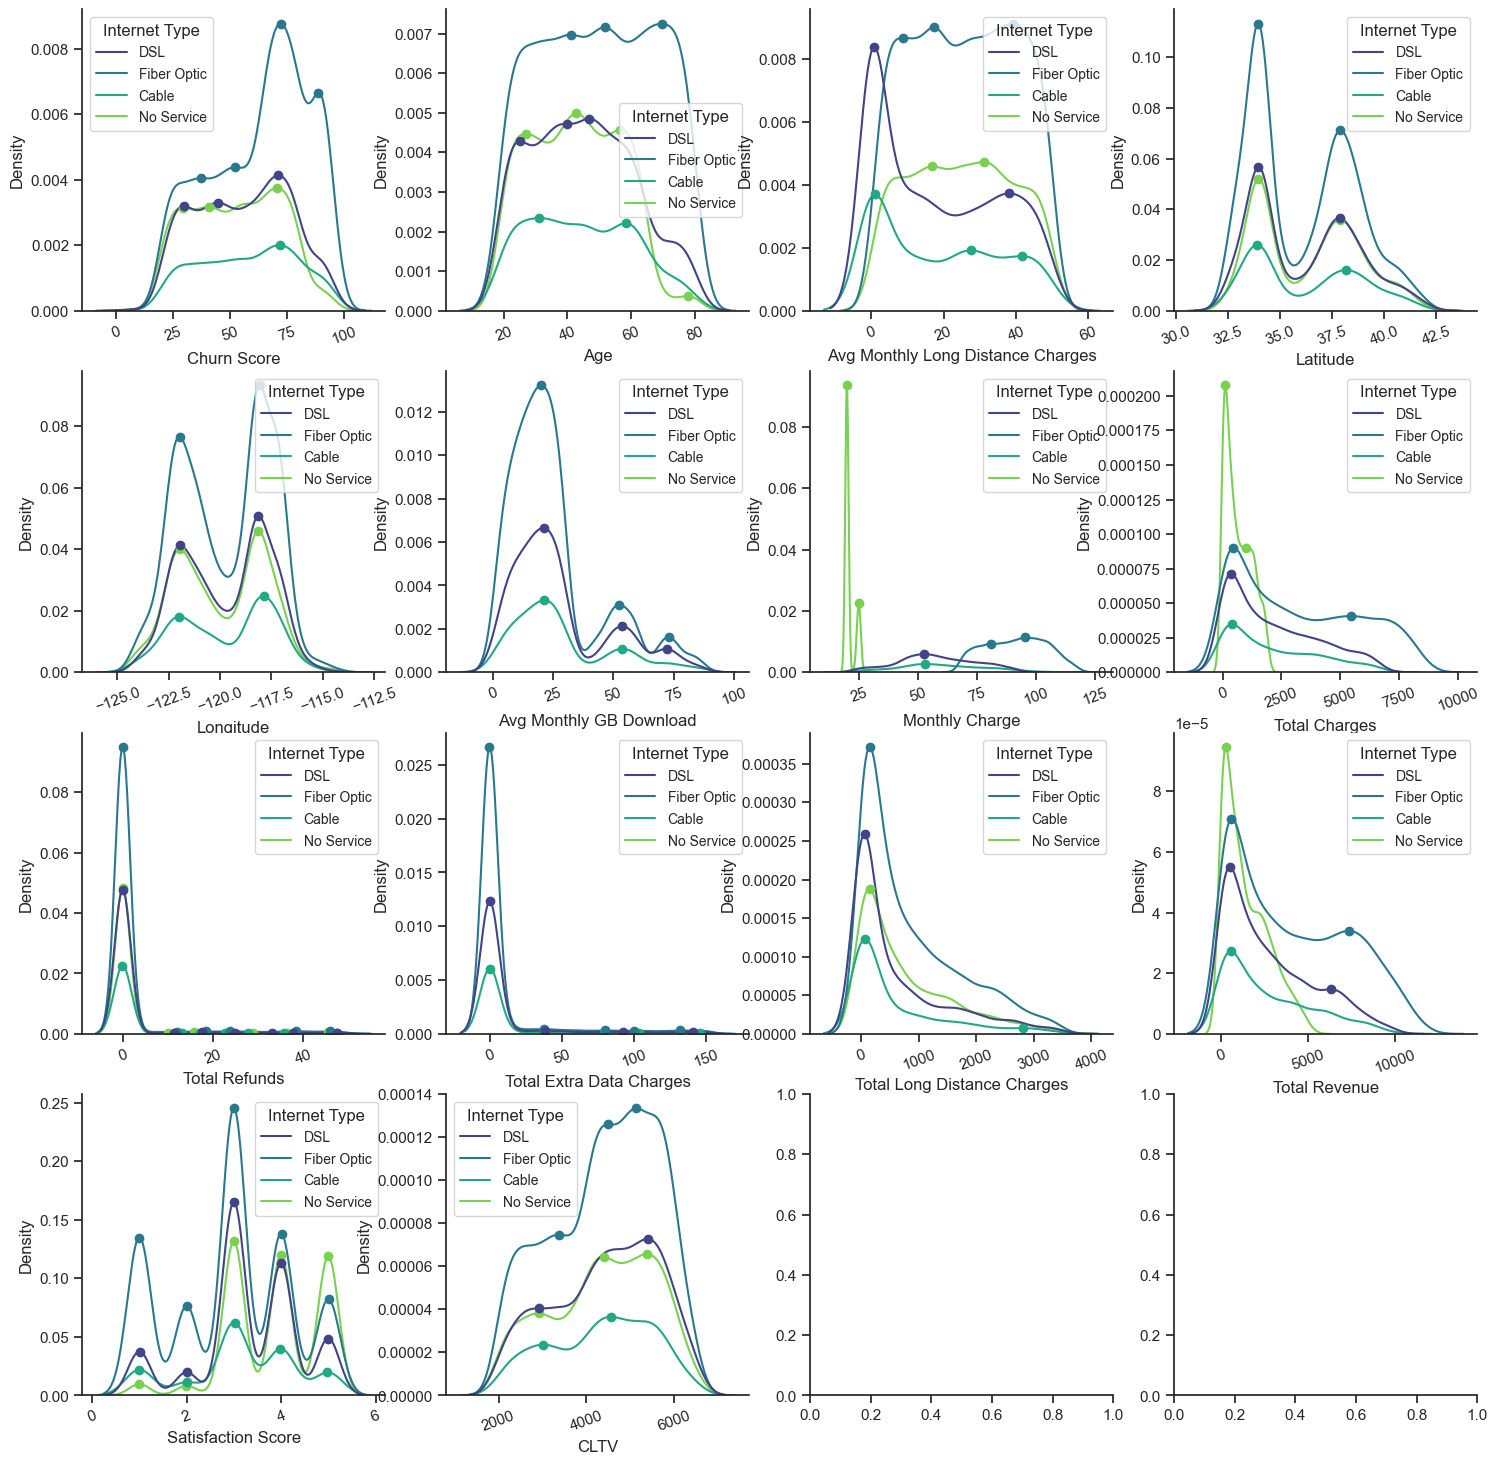

In [45]:
kdeplot_with_lines(names, 'Internet Type')
# 'Multiple Lines', 'Internet Type', 'Contract', 'Paperless Billing',
    #    'Payment Method'

*Internet service*: shows **important interaction with Churn Score**, *monthly charges*, *Total Revenue* and the *satisfaction score*.
- Among the internet services, **Fiber optic** represents the right part of the kernel in monthly, total charges and revenue. **Higher prices and high revenue comes from this service**, so the model have to considerer this variable.
- Observing the satisfaction score, **Fiber optic** presents a great acumulation of values below 3.
- Considering the two arguments presented, **Fiber optic** service shows problems, the cause should be studied. **It could be associated with 'price', or the service itself, maybe competition in nearby places**. Observing latitude and longitude this service is present in two main sectors that arise observing the coordinates. 

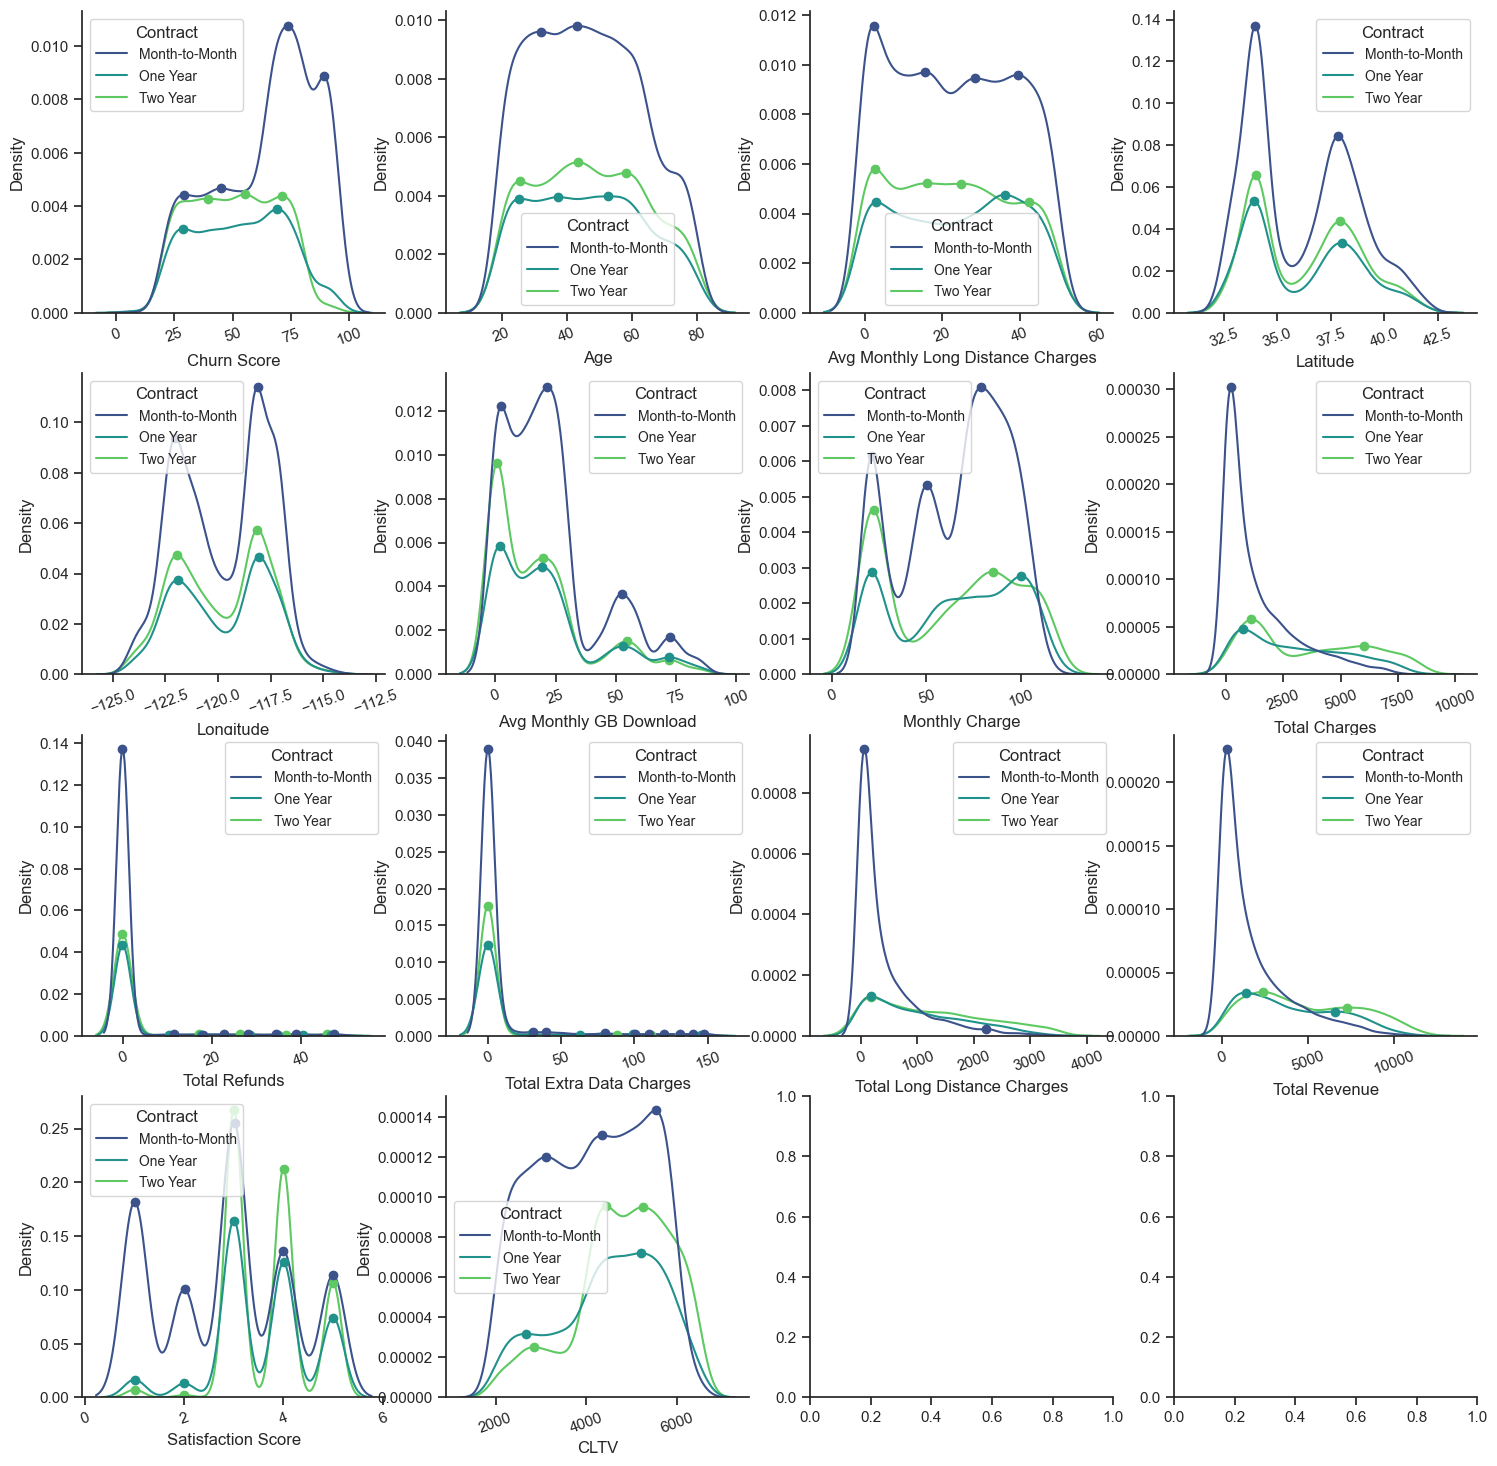

In [46]:
kdeplot_with_lines(names, 'Contract')
# 'Multiple Lines', 'Internet Type', 'Contract', 'Paperless Billing',
    #    'Payment Method'

*Contract* : **High interaction with Churn Score**, *Total Charges*, *Total Revenue*, *Satisfaction Score* and *CLTV*.
- Observing the interactions a **high amount of Churns should come from Month to Month contracts**.
- *The left side of the kernel of *Total Charges* and *Total Revenue* is highly represented by Month to Month contracts.*
- Satisfaction score for clients with longer contracts tends to start from 3 or above.
- **Satisfaction score is more regularly distributed for Month to Month, indicating that there are potential clients in this segment**. This argument is **highly correlated with** the results observed in ***CLTV* for Month to Month contracts.**

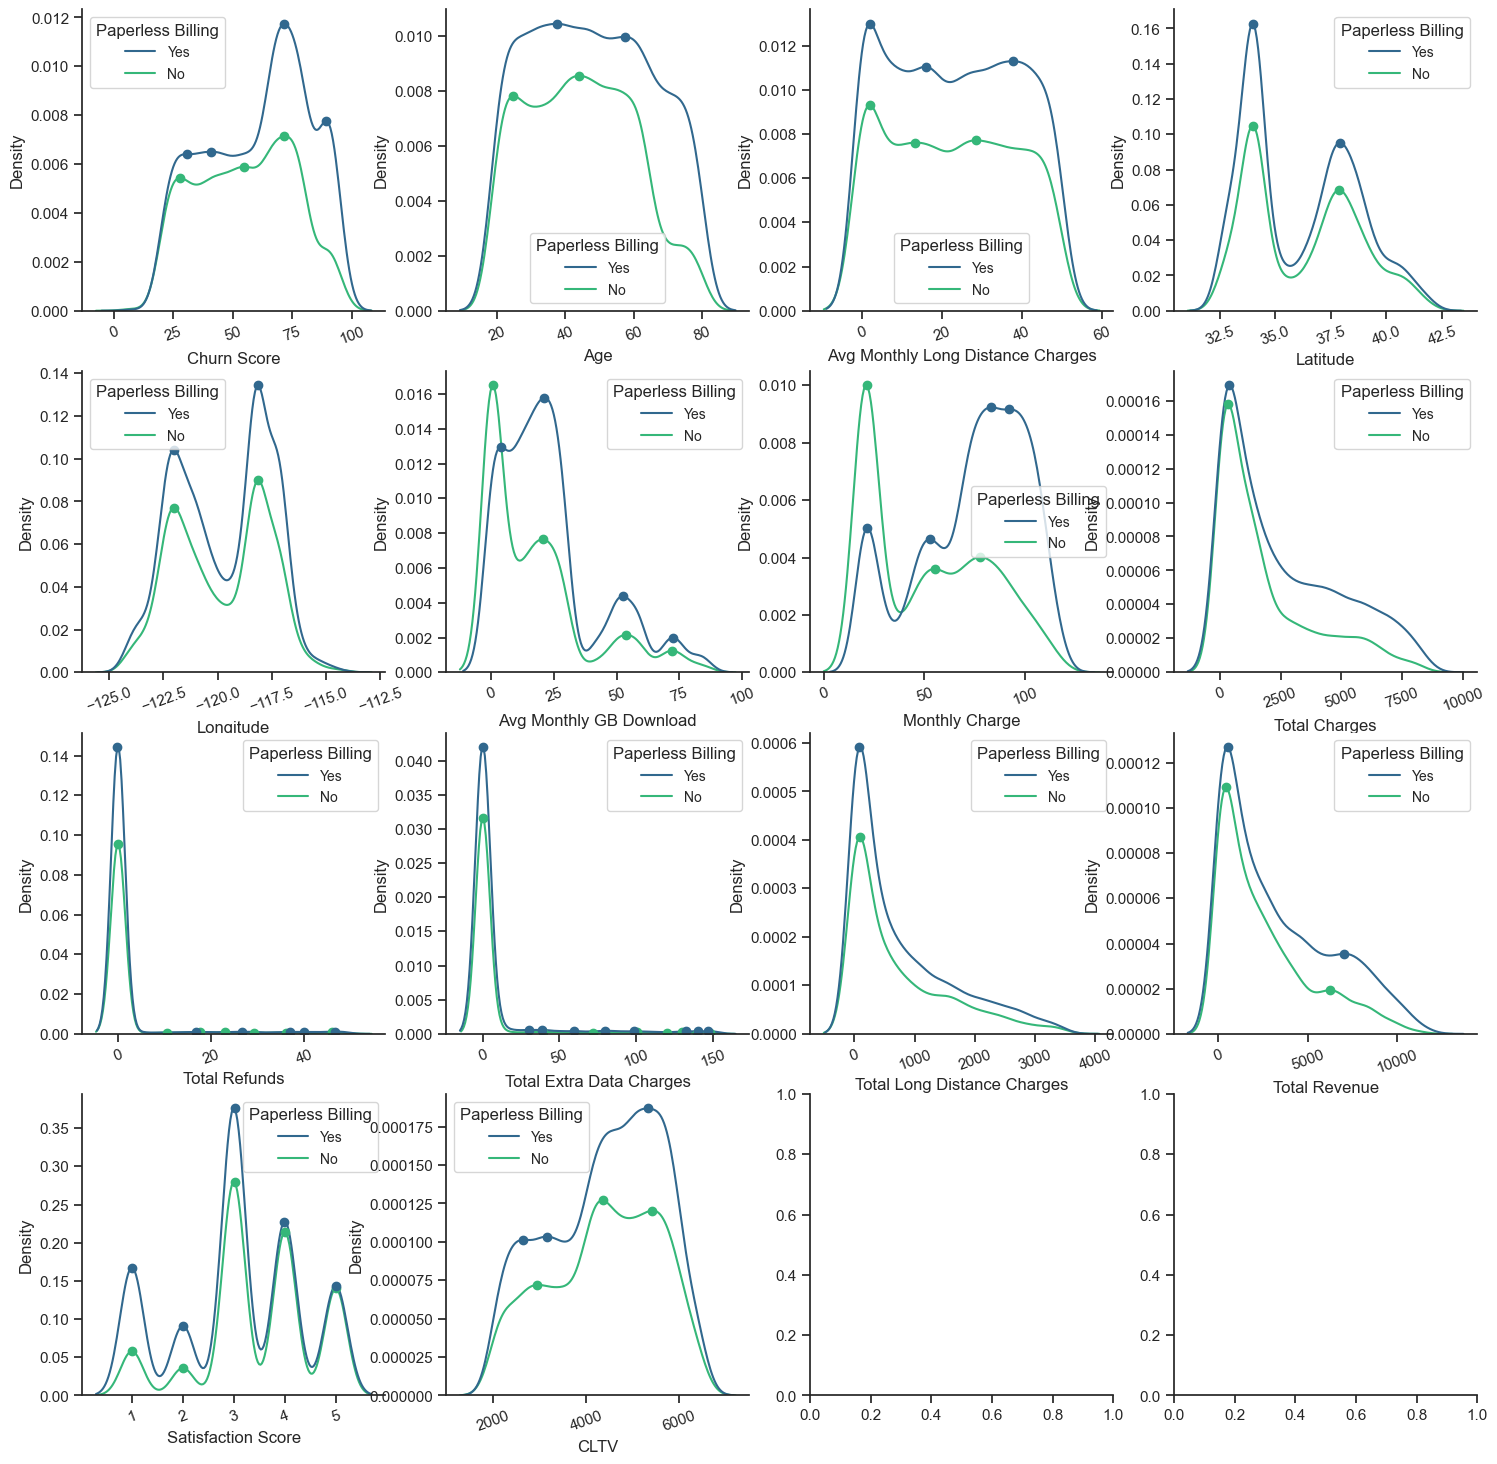

In [47]:
kdeplot_with_lines(names, 'Paperless Billing')
# 'Multiple Lines', 'Internet Type', 'Contract', 'Paperless Billing',
    #    'Payment Method'

*Paperless Billing*: **shows high interaction with Monthly Charges**.
- Clients with high monthly charges use paperless billing.
- Clients with low monthly charges uses different methods.
- ¿Does the method influence the service?, by visual inspection, yes. Considerations have to be taken when modelling this variable. 

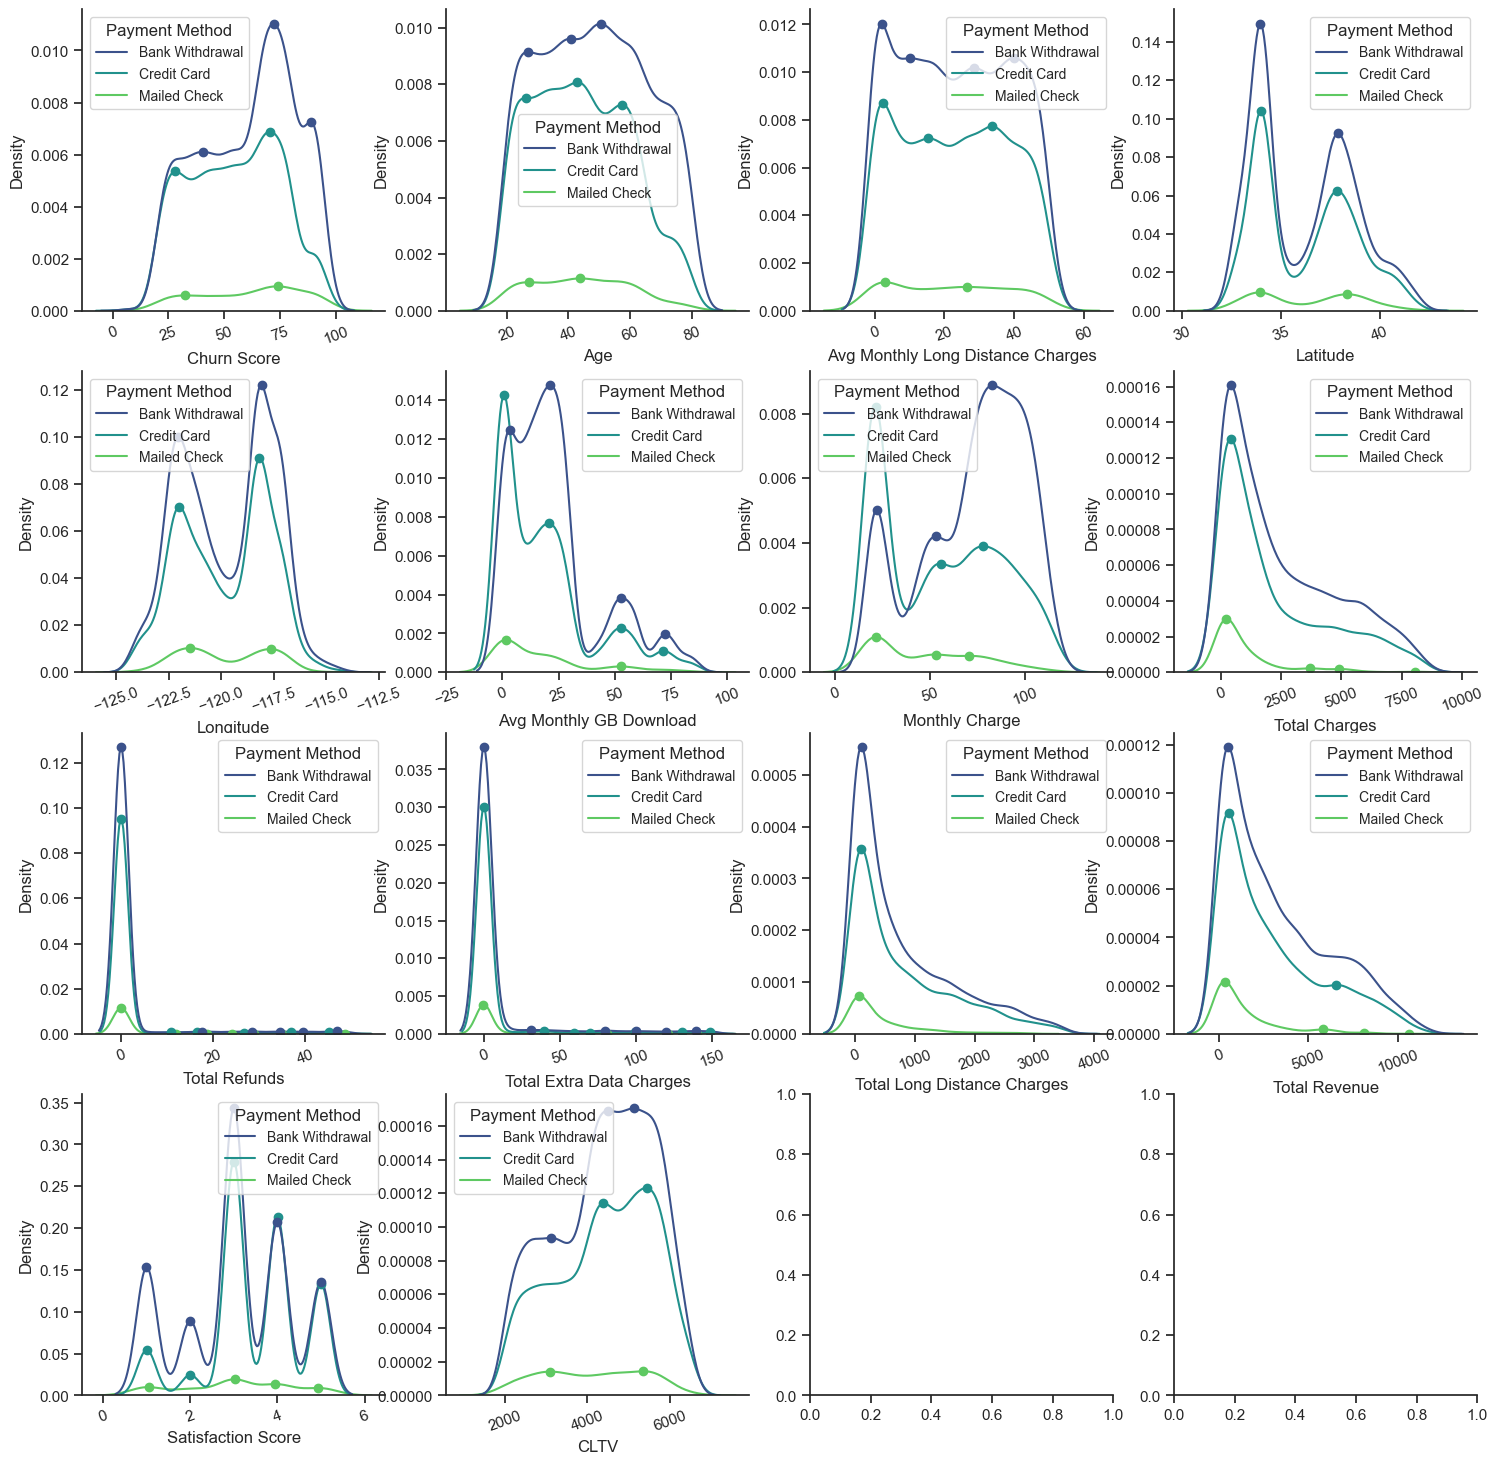

In [48]:
kdeplot_with_lines(names,  'Payment Method')
# 'Multiple Lines', 'Internet Type', 'Contract', 'Paperless Billing',
    #    'Payment Method'

*Payment Method*: At first, it should be noted that, an important part of the clients uses **Bank Withdrawal** and **Credit Card** payment methods.
- Among the payment methods, *Credit Card* shows better **Satisfaction Score** distribution, a low part of the clients have less than 2 scores.
- The right part of the Monthly Charges kernel is mainly composed by people who uses **Bank Withdrawal**.
- Mailed Check is less used (The kernel density is less prominent)
- No big interaccion is observed with other variables rather than the amount of clients who uses every method.
- If we count the amount of clients who uses every product the ranking would look like: **Bank Withdrawal**, **Credit Card** and **Mailed Check**

# Determination of categorical variable importance

### We start by determining what variables are important and where we can use dimensionality reduction for categorical variables

Start by importing useful packages

In [49]:
from sklearn.feature_selection import chi2, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, QuantileTransformer, StandardScaler, OneHotEncoder
from prince import MCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold


Generate a set of `LabelEncoded` variables to apply different test

In [50]:
lab_encoder = LabelEncoder()

cat_data_bool = data_df.dtypes == "object"
cat_data_names = data_df.columns[plotable_data_bool].values
cat_data_df = data_df[cat_data_names]

cat_data_df.drop(["Customer ID", "State", "Churn Category","City"], axis=1, inplace=True)
cat_data_df_encoded = cat_data_df.apply(lambda col: lab_encoder.fit_transform(col))
cat_data_df_encoded


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Gender  Married  Dependents  Offer  Multiple Lines  Internet Type  \
0          1        0           0      0               1              1   
1          0        1           1      5               2              2   
2          1        0           1      4               2              2   
3          0        1           1      3               0              2   
4          0        1           1      3               2              2   
...      ...      ...         ...    ...             ...            ...   
7038       0        0           0      0               0              3   
7039       1        1           1      3               2              0   
7040       0        1           1      0               2              2   
7041       0        1           1      0               1              1   
7042       1        0           0      0               0              2   

      Online Security  Online Backup  Device Protection Plan  \
0                   0              0                       2   
1                   0              2                       0   
2                   0              0                       0   
3                   0              2                       2   
4                   0              0                       0   
...               ...            ...                     ...   
7038                1              1                       1   
7039                2              0                       2   
7040                0              2                       2   
7041                2              0                       0   
7042                2              0                       2   

      Premium Tech Support  Streaming TV  Streaming Movies  Streaming Music  \
0                        0             0                 2                0   
1                        0             0                 0                0   
2                        0             2                 2                2   
3                        0             2                 2                0   
4                        0             0                 0                0   
...                    ...           ...               ...              ...   
7038                     1             1                 1                1   
7039                     2             2                 2                2   
7040                     0             2                 2                2   
7041                     0             0                 0                0   
7042                     2             2                 2                2   

      Unlimited Data  Contract  Paperless Billing  Payment Method  
0                  0         0                  1               0  
1                  2         0                  1               1  
2                  2         0                  1               0  
3                  2         0                  1               0  
4                  2         0                  1               0  
...              ...       ...                ...             ...  
7038               1         2                  1               0  
7039               2         1                  1               2  
7040               2         1                  1               1  
7041               2         0                  1               0  
7042               2         2                  1               0  

[7043 rows x 17 columns]

Apply `mutual_info_classif` and `chi2` test, to determine importance of variables 

In [51]:
chi2_stats, p_values = chi2(cat_data_df_encoded, data_df["Churn Value"])
importance_ = mutual_info_classif(cat_data_df_encoded, data_df["Churn Value"])


Generate a model using just categorical variables to explore `feature_importances_`

In [52]:
rf_model_cls = RandomForestClassifier()
rf_model_cls.fit(cat_data_df_encoded, data_df["Churn Value"])
feature_importance_qtl = rf_model_cls.feature_importances_


Plot results

<Axes: >

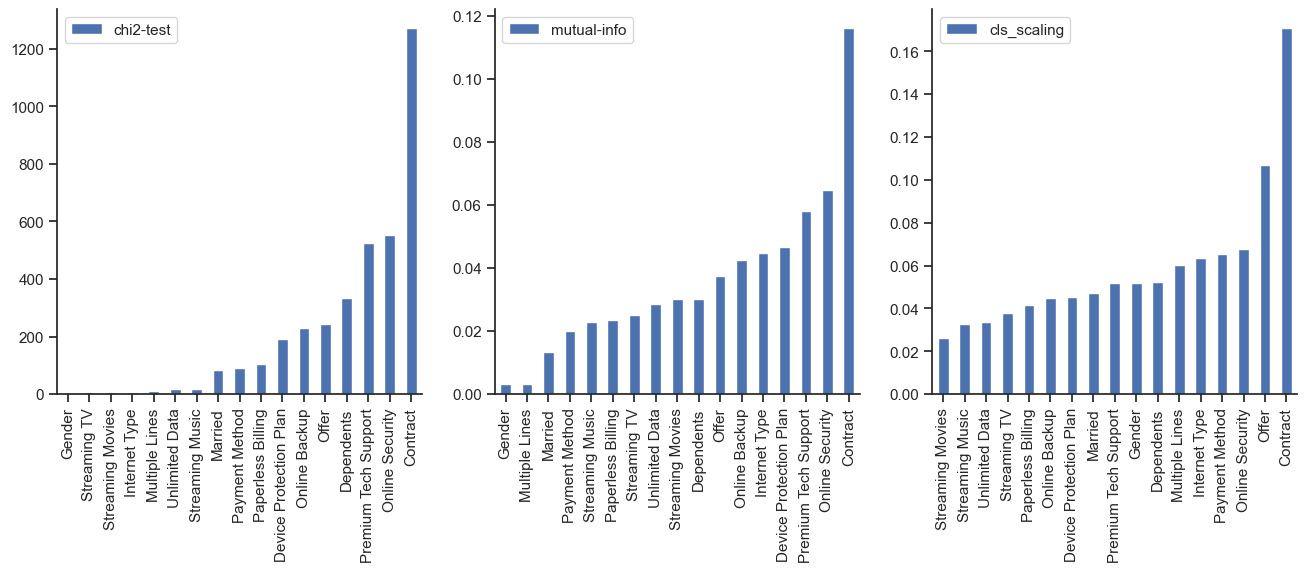

In [53]:
_, ax = plt.subplots(1,3, figsize=(16,5))
df_importace_ = pd.DataFrame(importance_, index=data_df.columns[plotable_data_bool].drop(["Customer ID", "State","City", "Churn Category"]),
                             columns= ["mutual-info"]).sort_values(by="mutual-info")\
                    .plot(kind="bar",ax=ax[1])

df_chi2 = pd.DataFrame(chi2_stats, index=data_df.columns[plotable_data_bool].drop(["Customer ID", "State","City", "Churn Category"]),
                       columns= ["chi2-test"]).sort_values(by="chi2-test")\
            .plot(kind="bar",ax=ax[0])

pd.DataFrame(feature_importance_qtl, index=cat_data_df_encoded.columns,
            columns= ["cls_scaling"]).sort_values(by="cls_scaling")\
    .plot(kind="bar",ax=ax[2])



- Observing the results, **Multiple Lines** and **Gender** coincides in both test for low importance, so we drop them.
- Both test show **Contract** and **Churn category** as important variables
- Internet type shows importance in mutual_info and no importance in chi2 test, we keep this value for further dimensionality reduction.
- Variables dropped in analysis: **Multiple Lines**, **Gender**.

`drop()` variables `Multiple, Lines, Gender` from categorical variables

In [54]:
cat_data_df.drop(["Multiple Lines","Gender"], axis=1, inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# Determination of best transformer for numerical data

We study three posible scenarios, `QuantileTransformer` with different `output_distribution`, and `StandardScaler`

In [55]:
def get_models():
 models = dict()
 for i in range(1,5):
    # define the pipeline
    trans = QuantileTransformer(n_quantiles=i, output_distribution='uniform')
    model = RandomForestClassifier()
    models[str(i)] = Pipeline(steps=[('t', trans), ('m', model)])
 return models


def evaluate_model(model, X, y):
 cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
 scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1, error_score='raise')
 return scores
 

Create numerical variables

In [56]:
num_data_bool = data_df.dtypes != "object"
num_data_names = data_df.columns[num_data_bool].values
num_data_df = data_df[num_data_names]
num_data_df
num_data_df.drop(["Churn Value", "Churn Score", "Satisfaction Score"], axis=1, inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Run the analysis

In [57]:
# define dataset
XX = num_data_df
Y  = data_df["Churn Value"]
# get the models to evaluate
models = get_models()
model_with_normal_dist = Pipeline(steps=[('t', QuantileTransformer(output_distribution='normal')),
                                         ('m', RandomForestClassifier())])
model_with_std_scaler = Pipeline(steps=[('t', StandardScaler()),
                                         ('m', RandomForestClassifier())])
# evaluate the models and store results
results = list()
for name, model in models.items():
 scores = evaluate_model(model, XX, Y)
 results.append(np.mean(scores))
 print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
 
scores_qtl_normal = evaluate_model(model_with_normal_dist, XX, Y)
scores_std = evaluate_model(model_with_std_scaler, XX, Y)

print(f"Qtl transformer best qtl uniform score: {results}")
print(f"Qtl transformer normal dist score: {np.mean(scores_qtl_normal)}")
print(f"Std transformer score: {np.mean(scores_std)}")


>1 0.500 (0.000)
>2 0.868 (0.014)
>3 0.866 (0.013)
>4 0.867 (0.013)
Qtl transformer best qtl uniform score: [0.5, 0.8675188889908813, 0.8659970161530487, 0.8670342422829495]
Qtl transformer normal dist score: 0.8665830079032157
Std transformer score: 0.8676552495792732


From this analysis we determine that `QuantileTransformer` with normal distribution gives the best results

# Determination of numerical variable importance

We start by applying our chosen `QuantileTransformer` to our usable data

In [58]:
qtl_encoder = QuantileTransformer(output_distribution='normal')

num_data_bool = data_df.dtypes != "object"
num_data_names = data_df.columns[num_data_bool].values
num_data_df = data_df[num_data_names]
num_data_df
num_data_df.drop(["Churn Value", "Churn Score", "Satisfaction Score"], axis=1, inplace=True)
num_data_df_encoded_qtl = pd.DataFrame(qtl_encoder.fit_transform(num_data_df), columns=[num_data_df.columns])




A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Fit a simple `RandomForestClassifier` to study `feature_importances_`

In [59]:
rf_model_qtl = RandomForestClassifier()
rf_model_qtl.fit(num_data_df_encoded_qtl, data_df["Churn Value"])
feature_importance_qtl = rf_model_qtl.feature_importances_


Plot the results

<Axes: >

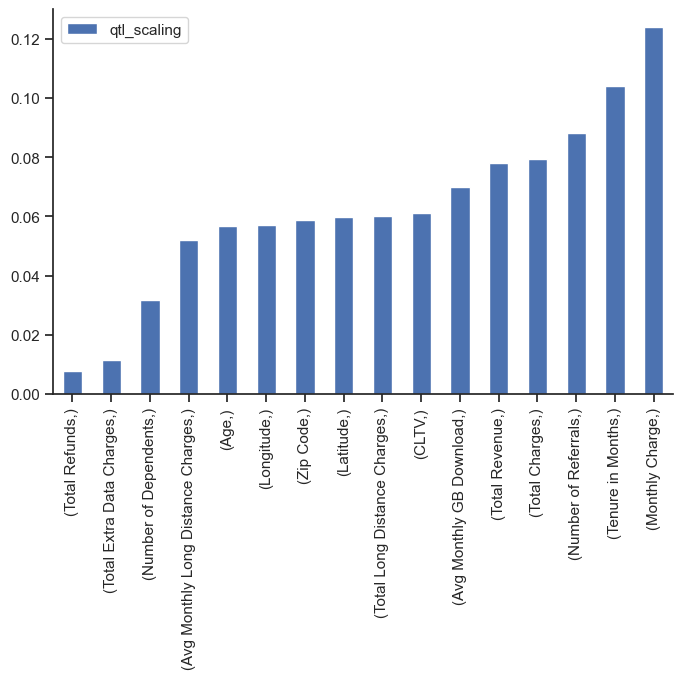

In [60]:
_, ax = plt.subplots(1,1, figsize=(8,5))


pd.DataFrame(feature_importance_qtl, index=num_data_df_encoded_qtl.columns,
            columns= ["qtl_scaling"]).sort_values(by="qtl_scaling")\
    .plot(kind="bar",ax=ax)



- From the plot, both Encoders suggest that the least important variables are **Total refunds** and **Total Extra Data Charges**, so, we drop them.
- Variables with low importance are used in a dimensionality reduction problem trying to understand if there could be a relation with some important variable.
- It is noticeable that **Monthly Charge, Tenure time, Number of referals and Satisfaction Score are the most important variables**.

`drop()` variables `Total Refunds, Total Extra Data Charges` from the usable numerical variables

In [61]:
num_data_df.drop(["Total Refunds","Total Extra Data Charges"], axis=1, inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Importance of all variables together

Using the same method of a `RandomForestClassifier` to obtain `feature_importances_`

In [62]:
rf_model_ttl = RandomForestClassifier()

num_data_df_encoded_ttl = pd.concat([num_data_df_encoded_qtl, cat_data_df_encoded],axis=1,ignore_index=True)
num_data_df_encoded_ttl
rf_model_ttl.fit(num_data_df_encoded_ttl, data_df["Churn Value"])
feature_importance_qtl = rf_model_ttl.feature_importances_

<Axes: >

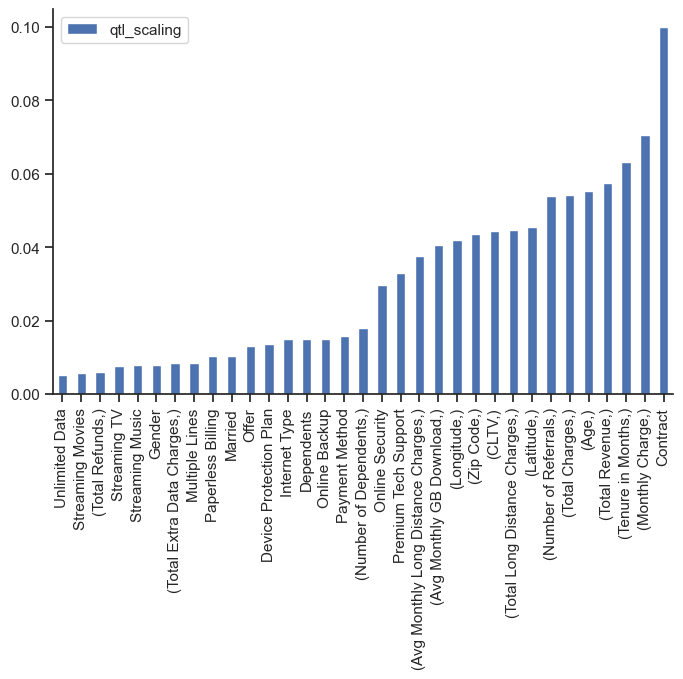

In [63]:
_, ax = plt.subplots(1,1, figsize=(8,5))


pd.DataFrame(feature_importance_qtl, index=np.concatenate([num_data_df_encoded_qtl.columns,cat_data_df_encoded.columns]),
            columns= ["qtl_scaling"]).sort_values(by="qtl_scaling")\
    .plot(kind="bar",ax=ax)


From the visual inspection, we choose to `drop()` every variable to the left of `Payment Method`

In [72]:
cat_drops = ["Offer","Streaming Movies","Unlimited Data","Streaming TV","Streaming Music","Device Protection Plan",
             "Married","Paperless Billing","Online Backup"]

In [73]:
cat_data_df.drop(cat_drops, axis=1, inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# Dimensionality reduction analysis

In [74]:
cat_data_df.shape

(7043, 6)

Observing the shape of categorical data, dimensionality reduction should aim to be less than 6 features.\
We start selecting a high value of components to explore the variance explained by different EigenValues

In [75]:
mca = MCA(n_components=10)
mca_values = mca.fit_transform(cat_data_df)

In [76]:
mca.eigenvalues_summary

eigenvalue % of variance % of variance (cumulative)
component                                                    
0              0.539        26.97%                     26.97%
1              0.304        15.20%                     42.17%
2              0.180         9.00%                     51.17%
3              0.169         8.45%                     59.62%
4              0.164         8.18%                     67.80%
5              0.152         7.62%                     75.42%
6              0.150         7.48%                     82.90%
7              0.125         6.24%                     89.14%
8              0.121         6.04%                     95.18%
9              0.096         4.82%                    100.00%

Observing the variance explained by EigenValues, There is no combination under 6 features that reach more than 95% variance explained. So the variables as they're cannot be reduced into transformations of less than 6 features.

# Numerical variables

In [77]:
num_data_df.shape

(7043, 14)

Create a table with encoded variables

In [78]:
num_data_df_encoded_qtl = pd.DataFrame(qtl_encoder.fit_transform(num_data_df), columns=[num_data_df.columns])

Apply `PCA` to reduce dimensions from 14 to a lower value

Text(0, 0.5, 'Explained variance %')

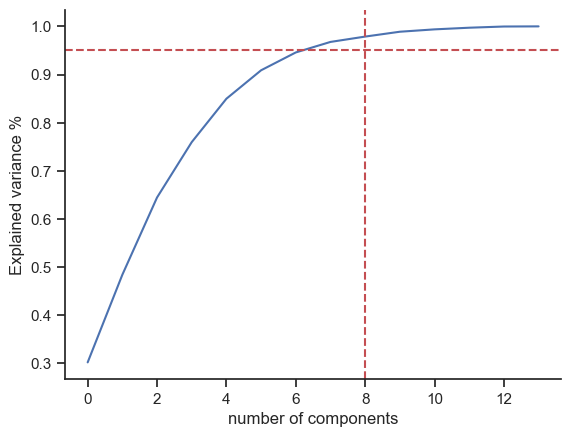

In [79]:
pca = PCA(n_components=14)
_, ax = plt.subplots()

# Fit PCA to your data
pca.fit(num_data_df_encoded_qtl)

# Get explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
# Get cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

sns.lineplot(cumulative_explained_variance, ax=ax)
ax.axhline(y=0.95, color='r', linestyle='--')
ax.axvline(x=8, color='r', linestyle='--')
ax.set_xlabel("number of components")
ax.set_ylabel("Explained variance %")


Using `PCA` we go from 14 initial variables to 8 numerical variables that are a transformation of initial data

In [80]:
import joblib

Create `X_data` and `Y_data`

In [81]:
X_data = data_df[np.concatenate([num_data_df.columns, cat_data_df.columns])]
Y_data = data_df["Churn Value"]

Create and save quantile transformer for numerical data

In [82]:
qlt_trans = QuantileTransformer(output_distribution='normal')
qlt_trans.fit(X_data[num_data_df.columns])


QuantileTransformer(output_distribution='normal')

In [83]:
joblib.dump(qlt_trans,"quantile_transformer_all_data.pkl")

['quantile_transformer_all_data.pkl']

In [84]:
std_trans = StandardScaler()
std_trans.fit(X_data[num_data_df.columns])

StandardScaler()

In [85]:
joblib.dump(std_trans,"std_transformer_all_data.pkl")

['std_transformer_all_data.pkl']

Create and save PCA model for numerical data

In [86]:
pca_model = PCA(n_components=8)
pca_model.fit(qlt_trans.transform(X_data[num_data_df.columns]))
np.cumsum(pca_model.explained_variance_ratio_)

array([0.30223286, 0.48424764, 0.64465126, 0.75961554, 0.84976165,
       0.90882191, 0.94585571, 0.96769774])

In [87]:
joblib.dump(pca_model,"pca_model_all_data.pkl")

['pca_model_all_data.pkl']

Export categorical features title and numerical features title

In [88]:
my_dict_cat = {"cat_variables_usable": cat_data_df.columns}
pd.DataFrame(my_dict_cat).to_csv("cat_variables_usable.csv")

my_dict_num = {"num_variables_usable": num_data_df.columns}
pd.DataFrame(my_dict_num).to_csv("num_variables_usable.csv")

How to read it, so the code works

In [89]:
cat_variable_usable = pd.read_csv("research\cat_variables_usable.csv")
cat_variable_usable = list(cat_variable_usable["cat_variables_usable"])


In [90]:
num_variable_usable = pd.read_csv("research/num_variables_usable.csv")
num_variable_usable = list(num_variable_usable["num_variables_usable"])


# Create a transformation pipeline for data

Import usable packages

In [91]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline

Create a `LabelEncoder()` in case of use inside the `Pipeline`

In [92]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder

class LabelEncoderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.encoders = {}

    def fit(self, X, y=None):
        for col in self.columns:
            le = LabelEncoder()
            le.fit(X[col])
            self.encoders[col] = le
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col, le in self.encoders.items():
            X_copy[col] = le.transform(X[col])
        return X_copy

    def get_feature_names_out(self, input_features=None):
        transformed_columns = []
        for col in self.columns:
            le = self.encoders[col]
            transformed_columns.extend([col + '_' + str(label) for label in le.classes_])
        return transformed_columns


Numerical `Pipeline` with `PCA(9)` for 99% variance described

In [93]:
numerical_pipeline = Pipeline([
    # ("Quantile_transformation", joblib.load("research\quantile_transformer_all_data.pkl")),
    ("Std_transformation", QuantileTransformer(output_distribution='normal')),
    ("PCA_transformation", PCA(9))
])

Categorical `Pipeline` using `OneHotEnconder`

In [94]:
categorical_pipeline = Pipeline([
    ("Label_encoder", OneHotEncoder())
])

Create a `preprocessor` variable for both types

In [95]:
preprocessor = ColumnTransformer(transformers=[
    ("Numerical_pipe", numerical_pipeline, num_variable_usable),
    ("Cat_pipeline", categorical_pipeline, cat_variable_usable )
])

Encoded_data  = preprocessor.fit_transform(X_data)


Create a `pandas.DataFrame` with columns names 

In [96]:
Encoded_df = pd.DataFrame(Encoded_data , columns= preprocessor.get_feature_names_out())

# Examine the correlations between PCA and real variables

For this task we employ a `heatmap`

<Axes: >

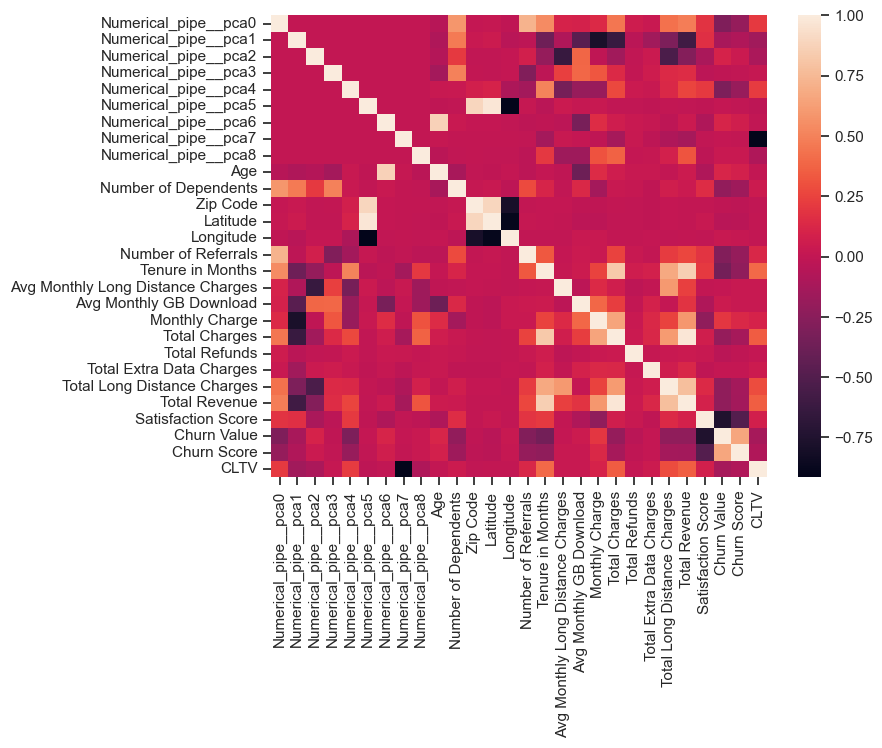

In [97]:
_,ax = plt.subplots(figsize = (8,6))
sns.heatmap(pd.concat([Encoded_df.iloc[:,:9], data_df[num_data_names]], axis=1).corr(), ax=ax)

- PCA 0-4: {*CLTV, Total Revenue, Total Long distance Charges, Total Charges, Monthly Charge , Tenure, Number of referals*}, main components are related to money and the behaviour in months.
- PCA 5: {Zip, Lat, Long}, main components are geolocations.


# Clustering Analysis

Import useful packages

In [98]:
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import silhouette_score
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import make_scorer, recall_score

from kmodes.kmodes import KModes


### Using enconded variables, we test `K-means` and `GaussianMixture` models to determine an aproximate number of clusters

Determine the start of Categorical variables

In [99]:
Encoded_df.iloc[:,9]

0       1.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
7038    1.0
7039    0.0
7040    0.0
7041    0.0
7042    1.0
Name: Cat_pipeline__Dependents_No, Length: 7043, dtype: float64

First try of clustering in 4 groups

In [113]:
kmeans = KMeans(n_clusters=4)
gmm    = GaussianMixture(n_components=4)
spc_clu= SpectralClustering(n_clusters=4)

kmeans.fit(Encoded_df)
gmm.fit(Encoded_df)



The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


GaussianMixture(n_components=4)

Evaluate the clustering results by `silhouette_score` with results in $[-1,1]$ <i>Higher is better</i> 


In [114]:
silhouette_avg = silhouette_score(Encoded_df, kmeans.labels_)
silhouette_avg2= silhouette_score(Encoded_df, gmm.predict(Encoded_df))
print(silhouette_avg,silhouette_avg2)

0.2803817587549054 0.28029047912156796


Both results are higher than 0, which implies a decent clustering.

Now we try a better approach with `K Prototypes`

Importing and fitting `K Prototypes` from `kmodes` package, first we determine the shape of table

In [ ]:
Encoded_df.shape

`.fit()` a simple model with 4 clusters to try the package use

In [115]:
from kmodes.kprototypes import KPrototypes
kP = KPrototypes(n_clusters=4, init='Huang', n_init=1, verbose=True)
kP.fit(Encoded_df, categorical= list(range(9, 26)))
kP.predict(Encoded_df, categorical= list(range(9, 26)))

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 1284, ncost: 199570.89216280988
Run: 1, iteration: 2/100, moves: 884, ncost: 191980.15654483958
Run: 1, iteration: 3/100, moves: 494, ncost: 188428.63105662627
Run: 1, iteration: 4/100, moves: 278, ncost: 185990.51679049784
Run: 1, iteration: 5/100, moves: 97, ncost: 185800.7845532851
Run: 1, iteration: 6/100, moves: 77, ncost: 185567.3950817137
Run: 1, iteration: 7/100, moves: 195, ncost: 183060.5237925269
Run: 1, iteration: 8/100, moves: 237, ncost: 180396.01039067435
Run: 1, iteration: 9/100, moves: 40, ncost: 180347.126132408
Run: 1, iteration: 10/100, moves: 0, ncost: 180347.126132408


array([3, 2, 1, ..., 2, 3, 1], dtype=uint16)

To find the appropiate number of cluster we applied the <b>elbow method</b>.

In [116]:

inertias = []
possible_k_values = range(2, 8)

for k in possible_k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=2)
    kmeans.fit(Encoded_df)
    # inertias.append(kmeans.inertia_)

    kP = KPrototypes(n_clusters=k, init='Huang', n_init=1, verbose=False)
    kP.fit_predict(Encoded_df, categorical=list(range(9, 26)))
    # inertias.append(kP.cost_)
    
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(Encoded_df)
    # bic_scores.append(gmm.bic(dd.drop(columns="Churn")))

    inertias_values = [kmeans.inertia_ , kP.cost_ , gmm.bic(Encoded_df)]
    inertias.append(inertias_values)


Plotting the results for the three methods

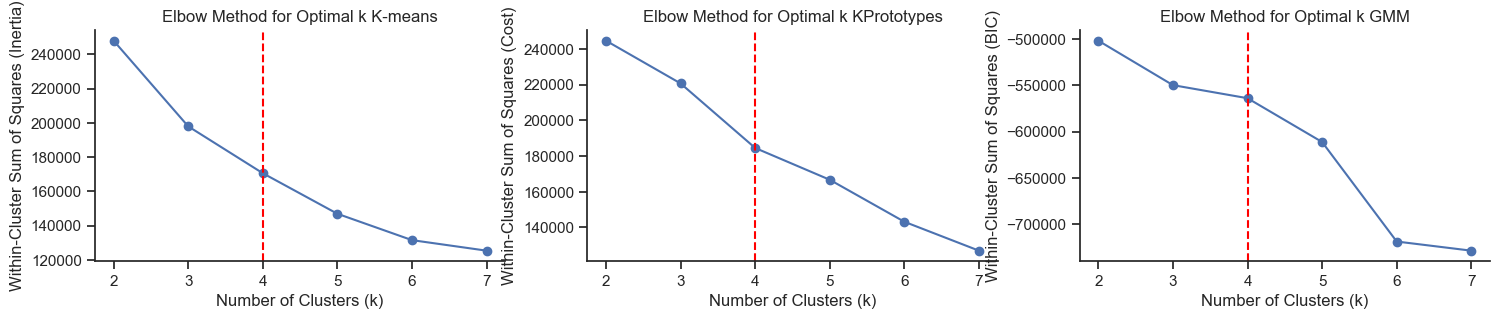

In [117]:
fig, ax = plt.subplots(1,3, figsize=(18,3))
axes = ax.ravel()
methods_str = ["K-means", "KPrototypes", "GMM"]
inertias_str = ["Inertia", "Cost", "BIC"]
inertias = pd.DataFrame(inertias, columns= inertias_str)

for index, axis in enumerate(axes):
    # Plot the elbow curve
    axis.plot(possible_k_values, inertias[inertias_str[index]], marker='o')
    axis.set_title(f'Elbow Method for Optimal k {methods_str[index]}')
    axis.set_xlabel('Number of Clusters (k)')
    axis.set_ylabel(f'Within-Cluster Sum of Squares ({inertias_str[index]})')
    axis.axvline(4, linestyle = "--", color = "red")

From the elbow method there is not a crystal clear value, so we evaluate the `silluete_score` of 4 clusters

In [118]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=2)
kmeans.fit(Encoded_df)
# inertias.append(kmeans.inertia_)

kP = KPrototypes(n_clusters=4, init='Huang', n_init=1, verbose=False)
# kP.fit(Encoded_df, categorical=list(range(8,26)))
# inertias.append(kP.cost_)

gmm = GaussianMixture(n_components=4, random_state=42)
gmm.fit(Encoded_df)

GaussianMixture(n_components=4, random_state=42)

In [119]:

silhouette_avg = silhouette_score(Encoded_df, kmeans.labels_)
silhouette_avg2= silhouette_score(Encoded_df, gmm.predict(Encoded_df))
silhouette_avg3= silhouette_score(Encoded_df, kP.fit_predict(Encoded_df, categorical=list(range(9, 26))))
print(silhouette_avg,silhouette_avg2,silhouette_avg3)

0.2803817587549054 0.28029047912156796 0.267899723803079


In this case, we choose can choose `GaussianMixture()` or `Kmeans()`, we pick the first.

#### Now we add the new clustering variable to the original dataset to understand the characteristics of the clusters

In [120]:
# kP = KPrototypes(n_clusters=4, init='Huang', n_init=1, verbose=False)
gmm = GaussianMixture(n_components=4, random_state=42)
gmm.fit(Encoded_df)
gmm.predict(Encoded_df)
new_groups = pd.DataFrame(gmm.predict(Encoded_df), columns=["New_class"])

`dump` the model to save it

In [121]:
joblib.dump(gmm,"research\gmm_cluster.pkl")

['research\\gmm_cluster.pkl']

We now group the data by the proposed cluster variables to determine which kind of customer is behind every cluster

In [122]:
all_numerical_data = pd.concat([data_df[num_data_df.columns],
                                data_df["Churn Value"],
                                Encoded_df.iloc[:,9:],
                                new_groups.astype(str)],axis=1)

# Visual summary

A visual summary is presented to observe the differences between Kernel densities of different categories

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
Dataset has 0 variance; skipping density estimate. Pass `warn_singular=Fa

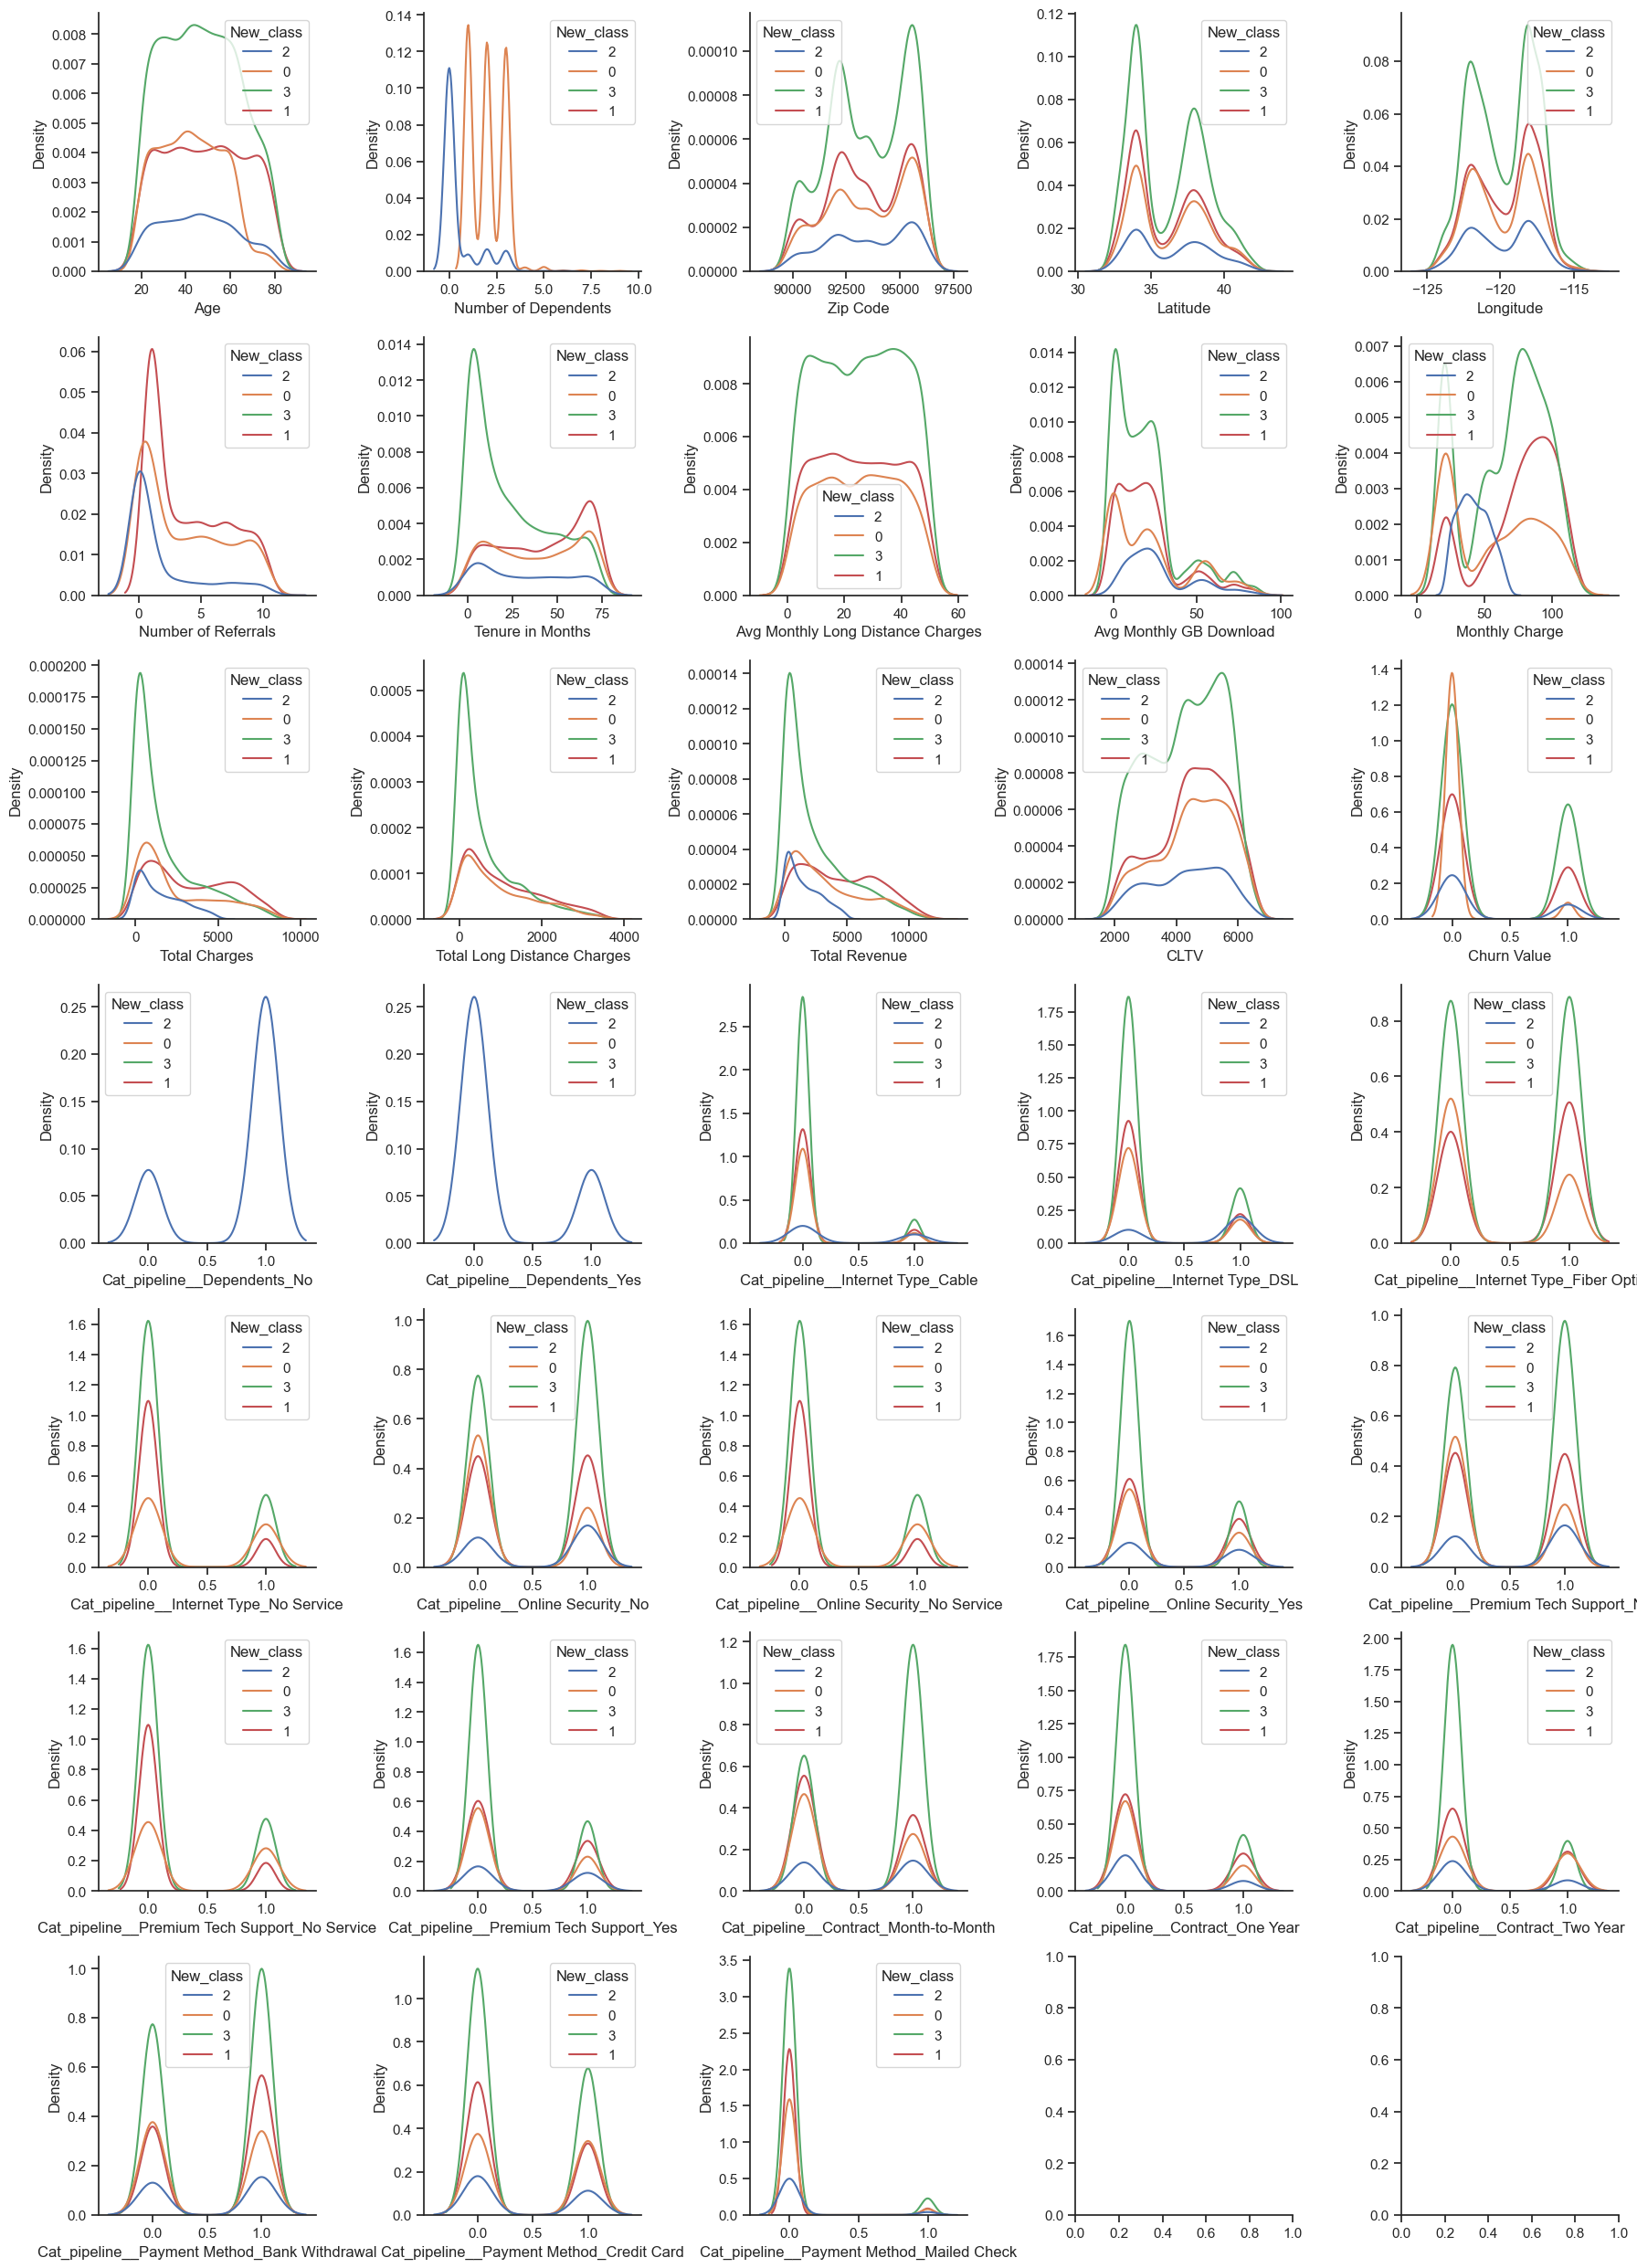

In [123]:
_, ax = plt.subplots(7,5,figsize=(18,25))

axes = ax.ravel()

for i,col in enumerate(all_numerical_data.columns):
    if col == "New_class":
        pass
    else:
        sns.kdeplot(x = all_numerical_data[col], hue=all_numerical_data["New_class"], ax = axes[i])

plt.tight_layout()
# sns.kdeplot(x = all_numerical_data["Tenure in Months"], hue=all_numerical_data["New_class"])

# Analysis by aggregation

For a summary with numbers, an aggregation is done with the new class as the grouping variable

In [124]:
pd.set_option('display.max_rows', None)
all_numerical_data.groupby("New_class").agg("mean").transpose()

New_class                                                 0             1  \
Age                                               42.749150     48.883838   
Number of Dependents                               2.019035      0.000000   
Zip Code                                       93527.010197  93422.477553   
Latitude                                          36.317002     36.076438   
Longitude                                       -119.831869   -119.658982   
Number of Referrals                                3.668933      3.974186   
Tenure in Months                                  38.616587     42.372054   
Avg Monthly Long Distance Charges                 25.219640     25.306347   
Avg Monthly GB Download                           21.955133     20.120651   
Monthly Charge                                    58.341672     76.951964   
Total Charges                                   2487.621237   3390.206089   
Total Long Distance Charges                      975.407104   1078.592593   
Total Revenue                                   3466.513895   4474.575471   
CLTV                                            4546.136642   4537.132435   
Churn Value                                        0.063222      0.293490   
Cat_pipeline__Dependents_No                        0.000000      1.000000   
Cat_pipeline__Dependents_Yes                       1.000000      0.000000   
Cat_pipeline__Internet Type_Cable                  0.097213      0.104938   
Cat_pipeline__Internet Type_DSL                    0.198504      0.191919   
Cat_pipeline__Internet Type_Fiber Optic            0.321550      0.558361   
Cat_pipeline__Internet Type_No Service             0.382733      0.144781   
Cat_pipeline__Online Security_No                   0.310673      0.501684   
Cat_pipeline__Online Security_No Service           0.382733      0.144781   
Cat_pipeline__Online Security_Yes                  0.306594      0.353535   
Cat_pipeline__Premium Tech Support_No              0.324269      0.497755   
Cat_pipeline__Premium Tech Support_No Service      0.382733      0.144781   
Cat_pipeline__Premium Tech Support_Yes             0.292998      0.357464   
Cat_pipeline__Contract_Month-to-Month              0.370496      0.397306   
Cat_pipeline__Contract_One Year                    0.220938      0.279461   
Cat_pipeline__Contract_Two Year                    0.408566      0.323232   
Cat_pipeline__Payment Method_Bank Withdrawal       0.474507      0.612233   
Cat_pipeline__Payment Method_Credit Card           0.477226      0.350168   
Cat_pipeline__Payment Method_Mailed Check          0.048266      0.037598   

New_class                                                 2             3  
Age                                               46.033774     47.032486  
Number of Dependents                               0.486050      0.000000  
Zip Code                                       93536.265786  93492.155355  
Latitude                                          36.342634     36.178455  
Longitude                                       -119.869457   -119.752408  
Number of Referrals                                1.861968      0.000000  
Tenure in Months                                  31.782673     23.848183  
Avg Monthly Long Distance Charges                  0.000000     25.572824  
Avg Monthly GB Download                           26.875184     18.667417  
Monthly Charge                                    42.052056     65.786475  
Total Charges                                   1498.994420   1717.359907  
Total Long Distance Charges                        0.000000    617.250000  
Total Revenue                                   1506.404097   2339.123535  
CLTV                                            4317.168869   4271.069154  
Churn Value                                        0.249633      0.348344  
Cat_pipeline__Dependents_No                        0.770925      1.000000  
Cat_pipeline__Dependents_Yes                       0.229075      0.000000  
Cat_pipeline_

In [125]:
pd.set_option('display.max_rows', 10)


### To verify the accuracy of clustering method we build a `simple classifier`

Import packages

In [126]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
import shap

Build a simple classiffier using `xgboost`

In [127]:
clf_kp = XGBClassifier(n_estimators = 400)

cv_scores_kp = cross_val_score(clf_kp,Encoded_df,new_groups, scoring='f1_weighted')
print(f'CV F1 score for K-Prototypes clusters is {np.mean(cv_scores_kp)}')

CV F1 score for K-Prototypes clusters is 0.99957467682806


With `F1 score` of 0.999 we now know that the cluster algorithm made a good work, so we proceed to fit the model

[20:29:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


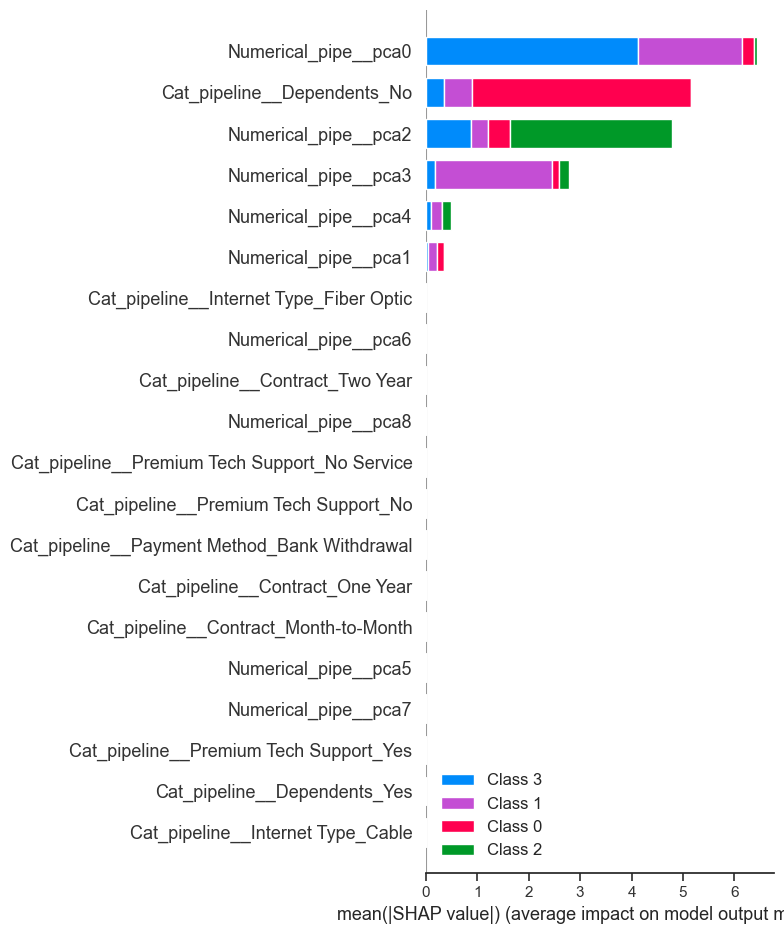

In [128]:
explainer = shap.TreeExplainer(clf_kp.fit(Encoded_df,new_groups))

# Step 3: Calculate SHAP values for your data
shap_values = explainer.shap_values(Encoded_df)

# Step 4: Plot the summary plot with categories
shap.summary_plot(shap_values, Encoded_df, plot_type="bar")

In [129]:
shap_values

[array([[-0.227204  , -0.1331547 , -1.4097531 , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.24763122, -0.12427451,  0.530947  , ...,  0.        ,
          0.        ,  0.        ],
        [-0.23922554, -0.12433779,  0.5373921 , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.3154004 , -0.12433779,  0.51662695, ...,  0.        ,
          0.        ,  0.        ],
        [-0.12683243, -0.10212457, -4.790804  , ...,  0.        ,
          0.        ,  0.        ],
        [-0.21834162, -0.12297501,  0.17375295, ...,  0.        ,
          0.        ,  0.        ]], dtype=float32),
 array([[-3.0662508 , -0.08651999, -1.7849354 , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.6764291 , -0.19179091,  0.05814116, ...,  0.        ,
          0.        ,  0.        ],
        [-0.17758057, -0.13575567,  0.01767719, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.7541588 ,  0.00803376,  0.0

## Apply a reset before start the fitting part

In [130]:
%reset -f

Import useful packages

In [131]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, FunctionTransformer, OrdinalEncoder, QuantileTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV,GridSearchCV
from xgboost import XGBClassifier, XGBRegressor
import xgboost
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc,make_scorer, recall_score, mean_absolute_percentage_error
import os
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.decomposition import PCA
from lightgbm import LGBMClassifier

import shap
import joblib

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

Set  working Directories

In [132]:
%pwd

'd:\\Repositories\\ml-churn'

In [133]:
os.chdir("d://Repositories/ml-churn/")

Read data

In [134]:
data_df = pd.read_csv("artifacts/data_preprocessing/usable_data.csv")

Read usable variables for classification model

In [135]:
cat_variable_usable = pd.read_csv("research\cat_variables_usable.csv")
cat_variable_usable = list(cat_variable_usable["cat_variables_usable"])

num_variable_usable = pd.read_csv("research/num_variables_usable.csv")
num_variable_usable = list(num_variable_usable["num_variables_usable"])

Build the `X_data` vector

In [136]:
X_data = data_df[np.concatenate([num_variable_usable, cat_variable_usable])]

Build the `Pipeline` without `PCA` for explainability

In [182]:
numerical_pipeline = Pipeline([
    ("Quantile_transformation", joblib.load("research\quantile_transformer_all_data.pkl")),
    # ("Std_transformation", joblib.load("research\std_transformer_all_data.pkl")),
    # ("PCA_transformation", PCA(9))
])
categorical_pipeline = Pipeline([
    ("One_hot_encoding", OneHotEncoder())
])
preprocessor = ColumnTransformer(transformers=[
    ("Numerical_pipe", numerical_pipeline, num_variable_usable),
    ("Cat_pipeline", categorical_pipeline, cat_variable_usable )
])

Encoded_data  = preprocessor.fit_transform(X_data)

Encoded_df = pd.DataFrame(Encoded_data , columns= preprocessor.get_feature_names_out())


Split data and apply `RandomizedSearchCV`

In [183]:
X_train, X_test, y_train, y_test = train_test_split(Encoded_df, data_df["Churn Value"],
                                                    test_size=0.3, random_state=42,
                                                    stratify=data_df["Churn Value"])

# Create a Gaussian Mixture model
xgb = XGBClassifier(objective='binary:logistic', random_state=42)


param_distributions = {
    'n_estimators': [100, 300, 500],
    'eta': [0.005, 0.01],
    'max_depth': [3, 4],
    'alpha': [0.03, 0.06],
    'lambda': [0.06],
    'eval_metric': ['aucpr'],
    'subsample': [0.5, 0.25],
    'colsample_bytree': [0.5, 0.25],
    'gamma': [5, 3, 8],
    'learning_rate': [0.05, 0.01, 0.1],
    'scale_pos_weight': [1.5, 1.0]
}

# Create RandomizedSearchCV object
random_search_xgb = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_distributions,
    n_iter=100,  # Number of parameter settings that are sampled
    cv=5,  # Number of cross-validation folds
    scoring="roc_auc",  # Scoring metric
    n_jobs=-1,  # Use all available CPU cores
    random_state=42  # Random seed for reproducibility

)

Verify splitting

In [184]:
(y_test == 1).sum()/y_test.count()

0.26549929010885

In [185]:
(y_train == 1).sum()/y_train.count()

0.2653144016227181

Apply `.fit()` method

In [186]:
random_search_xgb.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           random_state=42, ...),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'alpha': [0.03, 0.06],
                                        'colsample_bytree': [0.5, 0.25],
                                        'eta': [0.005, 0.01],
                                        'eval_metric': ['aucpr'],
                                        'gamma': [5, 3, 8], 'lambda': [0.06],
                                        'learning_rate': [0.05, 0.01, 0.1],
                                        'max_depth': [3, 4],
                                        'n_estimators': [100, 300, 500],
                                        'scale_pos_weight': [1.5, 1.0],
                                        'subsample': [0.5, 0.25]},
                   random_state=42, scoring='roc_auc')

In [187]:
random_search_xgb.best_score_

0.9078533093559858

In [188]:
results_xgb = pd.DataFrame(random_search_xgb.cv_results_)

In [192]:
results_xgb[results_xgb["rank_test_score"] == 1]

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
76       0.361683      0.027712         0.011912        0.002317   

   param_subsample param_scale_pos_weight param_n_estimators param_max_depth  \
76             0.5                    1.0                300               4   

   param_learning_rate param_lambda  ... param_alpha  \
76                 0.1         0.06  ...        0.03   

                                               params split0_test_score  \
76  {'subsample': 0.5, 'scale_pos_weight': 1.0, 'n...          0.925063   

   split1_test_score split2_test_score split3_test_score  split4_test_score  \
76           0.89976          0.905381          0.901823            0.90724   

    mean_test_score  std_test_score  rank_test_score  
76         0.907853        0.008995                1  

[1 rows x 24 columns]

Plot importances to verify EDA

<Axes: >

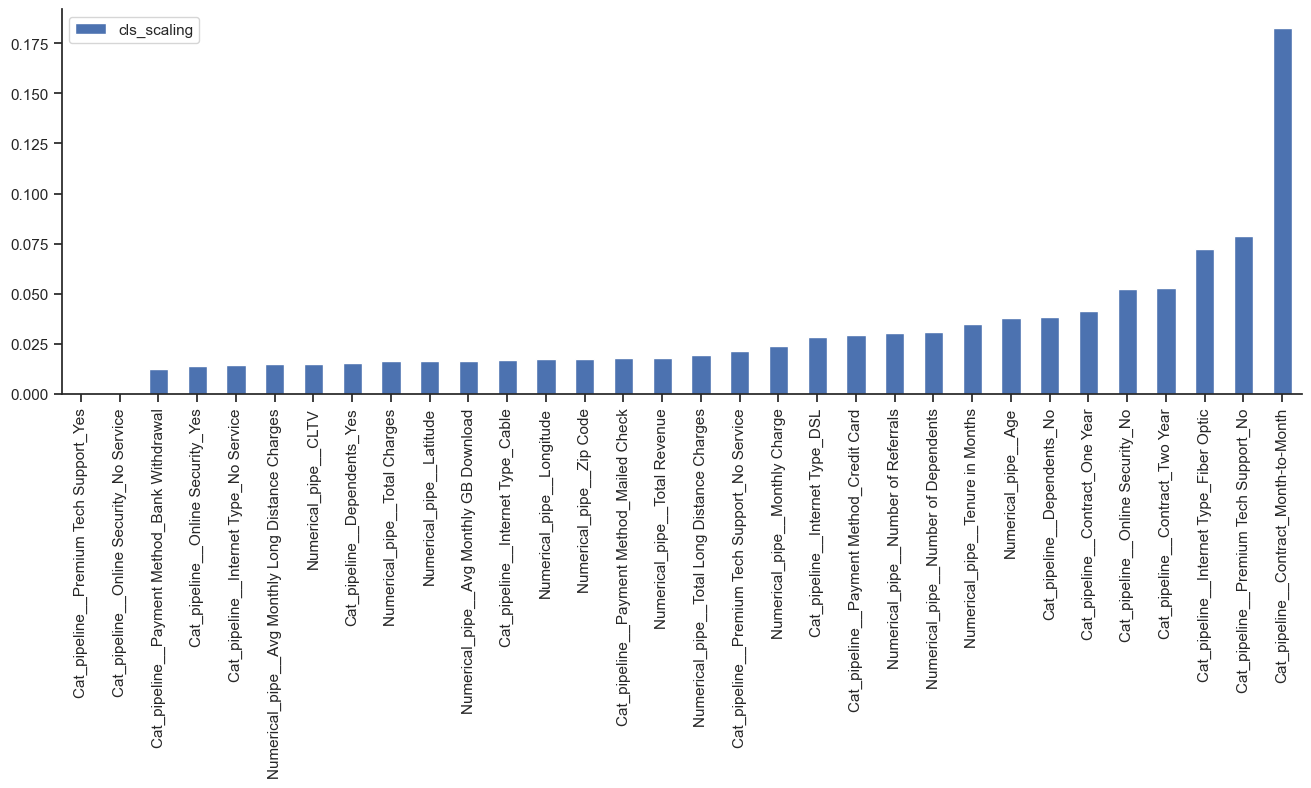

In [193]:
_, ax = plt.subplots(1,1, figsize=(16,5))

pd.DataFrame(random_search_xgb.best_estimator_.feature_importances_,
             index=X_train.columns,
             columns= ["cls_scaling"]).sort_values(by="cls_scaling")\
    .plot(kind="bar",ax=ax)

Plot `roc_auc` curve

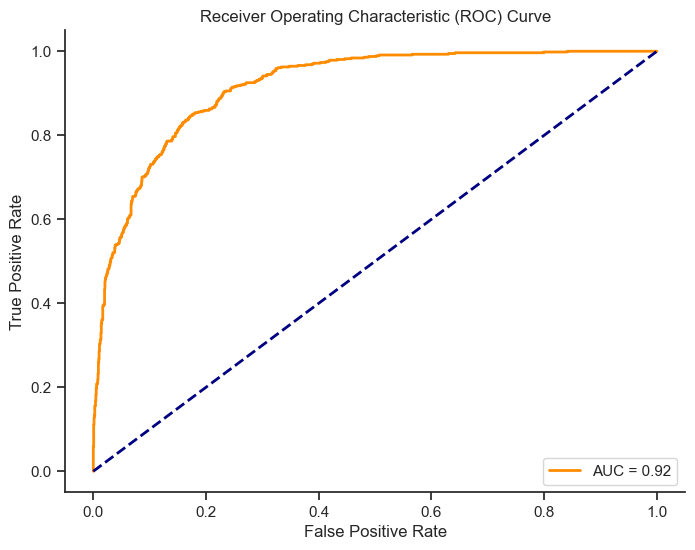

0.9165989029163681

In [194]:
best_model = random_search_xgb.best_estimator_
THRESHOLD = 0.4

# Predict probabilities on the test set
y_proba = best_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

roc_auc = auc(fpr, tpr)
app_prob = tpr[np.where(np.isclose(THRESHOLD, fpr,rtol=1e-2))]
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.axhline(np.mean(app_prob))
# plt.axvline(THRESHOLD)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
auc(fpr, tpr)

A high accuracy is observed from the fitted `xgboost` model, this mainly comes from the EDA results

Plot `Confusion Matrix`

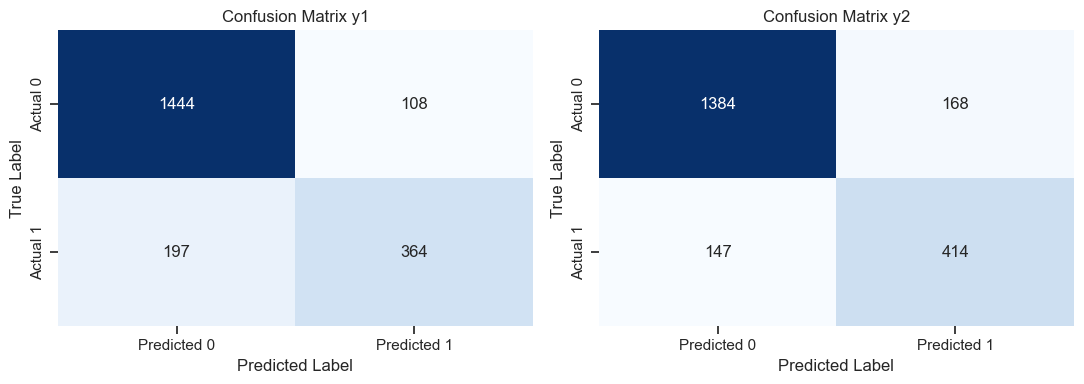

In [195]:
y_pred  = random_search_xgb.best_estimator_.predict(X_test)
y_pred1 = np.where(random_search_xgb.best_estimator_.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)

# Create a confusion matrix
y_preds = {"y1" : y_pred , "y2": y_pred1}


fig, ax = plt.subplots(1,2, figsize=(11,4))
axes = ax.ravel()

for axes,y_values in zip(axes , y_preds):

    conf_matrix = confusion_matrix(y_test, y_preds[y_values])
    # Plot the confusion matrix using seaborn
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'], ax = axes)
    axes.set_xlabel('Predicted Label')
    axes.set_ylabel('True Label')
    axes.set_title(f'Confusion Matrix {y_values}')

plt.tight_layout()

Define some metrics to understand the capabilities of the model

In [196]:

def calculate_metrics(conf_matrix):
    """
    Calculate various performance metrics from a confusion matrix.

    Parameters:
    - conf_matrix: 2x2 NumPy array, confusion matrix with rows representing actual classes
                  and columns representing predicted classes.

    Returns:
    - metrics_dict: Dictionary containing calculated performance metrics.
    """
    TP = conf_matrix[1, 1]  # True Positives
    TN = conf_matrix[0, 0]  # True Negatives
    FP = conf_matrix[0, 1]  # False Positives
    FN = conf_matrix[1, 0]  # False Negatives

    # Calculate metrics
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    specificity = TN / (TN + FP)
    f1_score = 2 * (precision * recall) / (precision + recall)
    fpr = FP / (FP + TN)
    fdr = FP / (TP + FP)
    fnr = FN / (TP + FN)
    mcc = (TP * TN - FP * FN) / np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))

    # Create a dictionary to store the metrics
    metrics_dict = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'Specificity': specificity,
        'F1 Score': f1_score,
        'False Positive Rate (FPR)': fpr,
        'False Discovery Rate (FDR)': fdr,
        'False Negative Rate (FNR)': fnr,
        'Matthews Correlation Coefficient (MCC)': mcc,
    }

    return metrics_dict


Setup a *Threshold* value usable for the client to twek the model

In [197]:
THRESHOLD = 0.4
y_pred1 = np.where(random_search_xgb.best_estimator_.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)
y_pred2 = random_search_xgb.best_estimator_.predict(X_test)
# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred1)
conf_matrix2 = confusion_matrix(y_test, y_pred2)

print(calculate_metrics(conf_matrix))
print(calculate_metrics(conf_matrix2))

{'Accuracy': 0.8509228584950308, 'Precision': 0.711340206185567, 'Recall': 0.7379679144385026, 'Specificity': 0.8917525773195877, 'F1 Score': 0.7244094488188977, 'False Positive Rate (FPR)': 0.10824742268041238, 'False Discovery Rate (FDR)': 0.28865979381443296, 'False Negative Rate (FNR)': 0.2620320855614973, 'Matthews Correlation Coefficient (MCC)': 0.6224808958684382}
{'Accuracy': 0.8556554661618552, 'Precision': 0.7711864406779662, 'Recall': 0.6488413547237076, 'Specificity': 0.9304123711340206, 'F1 Score': 0.7047434656340755, 'False Positive Rate (FPR)': 0.06958762886597938, 'False Discovery Rate (FDR)': 0.2288135593220339, 'False Negative Rate (FNR)': 0.3511586452762923, 'Matthews Correlation Coefficient (MCC)': 0.6141448794302314}


Calculate `shap` values

In [198]:
X1000 = shap.utils.sample(X_train, 1000)
explainer = shap.Explainer(random_search_xgb.best_estimator_.predict, X1000)
shap_values = explainer(X_train)

PermutationExplainer explainer: 4931it [06:23, 12.52it/s]                          


`Waterfall` for customer interpretations 

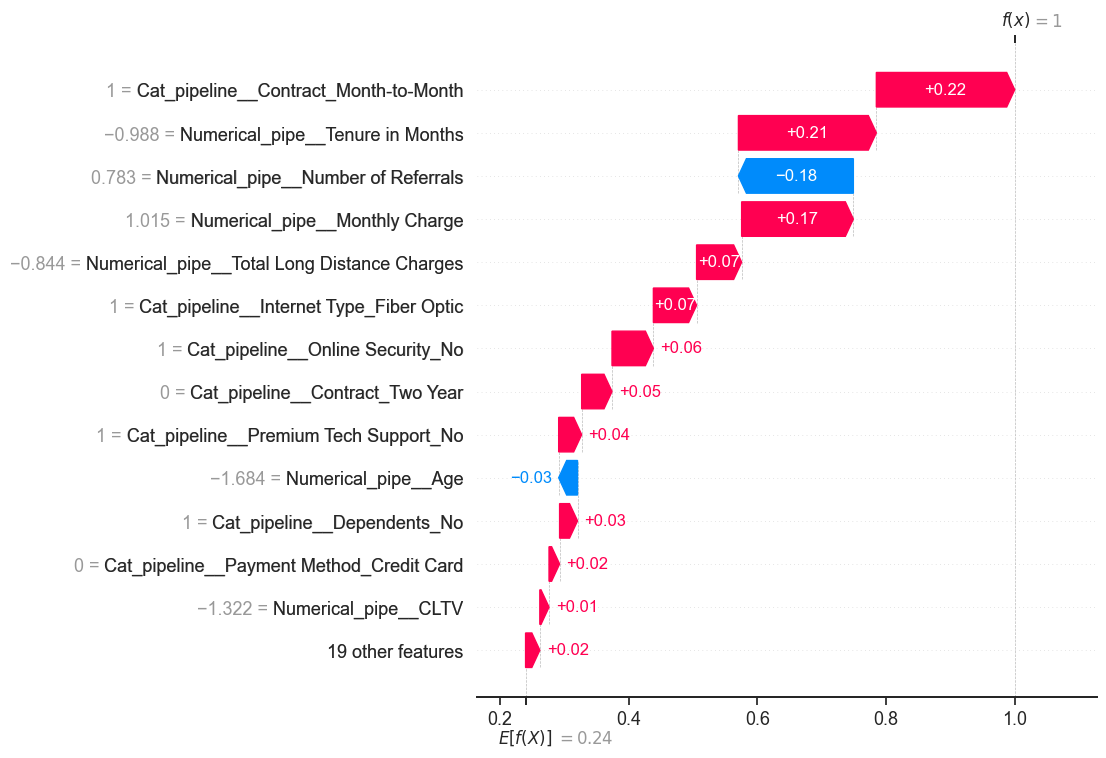

In [199]:
shap.plots.waterfall(shap_values[20], max_display=14)

`Beeswarm` for total interpretability

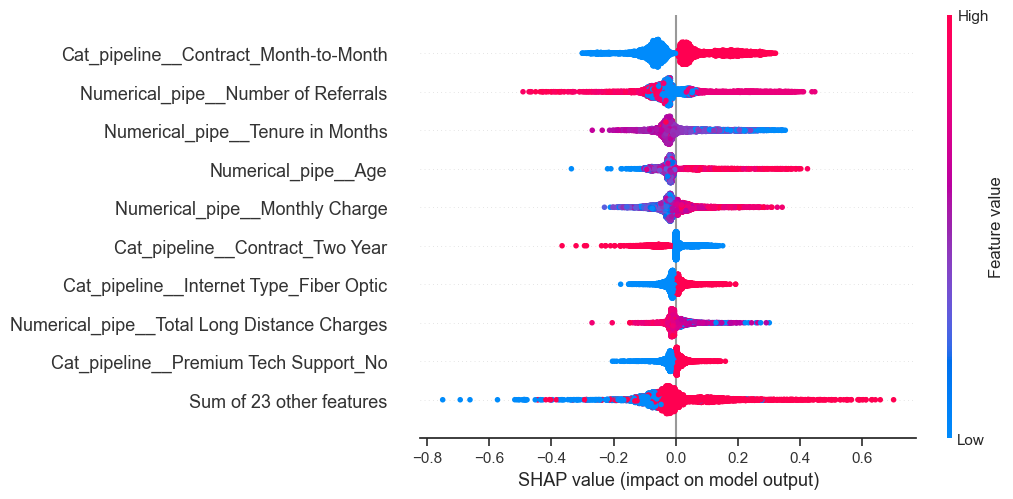

In [200]:
shap.plots.beeswarm(shap_values)

Main features coming from EDA are shown again in importance ratings from `shap`

Use summary plot 

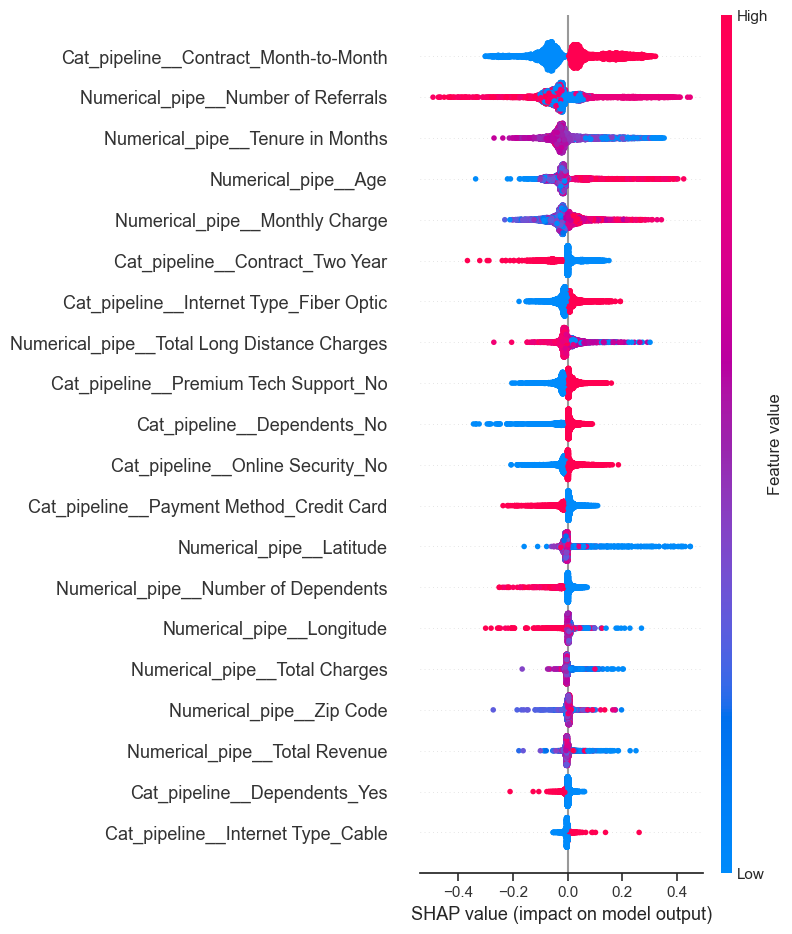

In [201]:
shap.summary_plot(shap_values)

Building a `pytorch` classifier to verify the accuracy of current model against another model class

In [152]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from skorch import NeuralNetClassifier
from skorch.callbacks import EarlyStopping


Converting input `X` and `y` values to tensors

In [153]:
X_train_tensor = torch.FloatTensor(X_train.to_numpy(dtype='float32'))
y_train_tensor = torch.FloatTensor(y_train.to_numpy(dtype='float32').reshape(-1, 1))
X_test_tensor = torch.FloatTensor(X_test.to_numpy(dtype='float32'))
y_test_tensor = torch.FloatTensor(y_test.to_numpy(dtype='float32').reshape(-1, 1))

Define new classes for `scorch` package

In [154]:
class CustomNN(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(CustomNN, self).__init__()
        layers = []
        prev_size = input_size
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.ReLU())
            prev_size = hidden_size
        layers.append(nn.Linear(prev_size, output_size))
        layers.append(nn.Sigmoid())
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Define the Skorch wrapper for the neural network
class CustomNetClassifier(NeuralNetClassifier):
    def __init__(self, module, **kwargs):
        super(CustomNetClassifier, self).__init__(module, **kwargs)

# Create a Skorch classifier
classifier = CustomNetClassifier(
    module=CustomNN,
    module__input_size=X_train.shape[1],
    module__hidden_sizes=[16, 8],  # Specify the hidden layer sizes as needed
    module__output_size=1,
    max_epochs=50,  # Adjust the maximum number of epochs as needed
    lr=0.001,
    optimizer=optim.Adam,
    criterion=nn.BCELoss,
    iterator_train__shuffle=True,
    callbacks=[EarlyStopping(patience=10)],
)


Use `GridSearchCV` to explore different configurations

In [155]:
X_train_tensor = X_train_tensor.float()
y_train_tensor = y_train_tensor.float()

# Training the model
classifier.fit(X_train_tensor, y_train_tensor)

# Evaluate the model on the test set
accuracy = classifier.score(X_test_tensor, y_test_tensor)
print(f'Test Accuracy: {accuracy:.4f}')

# Example usage with GridSearchCV
params = {
    'lr': [0.05,0.1,0.2],
    'module__hidden_sizes': [[64,16],[64,32,16],[64,32],[128,64,32,16]],
}

grid = GridSearchCV(classifier, params, cv=3, scoring='accuracy', verbose=0)
grid.fit(X_train_tensor, y_train_tensor)
print(f'Best parameters: {grid.best_params_}')
print(f'Best accuracy: {grid.best_score_}')

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7150       0.5811        0.6682  0.1410
      2        0.6215       0.7546        0.5678  0.1360
      3        0.5235       0.7535        0.4817  0.1500
      4        0.4626       0.7627        0.4359  0.1330
      5        0.4324       0.7951        0.4089  0.1280
      6        0.4159       0.8063        0.3934  0.1260
      7        0.4058       0.8144        0.3852  0.1290
      8        0.3991       0.8225        0.3808  0.1250
      9        0.3948       0.8245        0.3769  0.1240
     10        0.3907       0.8215        0.3760  0.1220
     11        0.3881       0.8174        0.3731  0.1270
     12        0.3853       0.8174        0.3722  0.1260
     13        0.3832       0.8164        0.3707  0.1280
     14        0.3811       0.8195        0.3692  0.1413
     15        0.3790       0.8185        0.3675  0.1330
     16        0.3775       0.8

Evaluation metrics for ANN model

In [156]:
y_pred = classifier.predict(X_test_tensor.float())
conf_matrix = confusion_matrix(y_test, y_pred)
print(calculate_metrics(conf_matrix))


{'Accuracy': 0.8343587316611453, 'Precision': 0.7064579256360078, 'Recall': 0.64349376114082, 'Specificity': 0.9033505154639175, 'F1 Score': 0.6735074626865672, 'False Positive Rate (FPR)': 0.09664948453608248, 'False Discovery Rate (FDR)': 0.29354207436399216, 'False Negative Rate (FNR)': 0.35650623885918004, 'Matthews Correlation Coefficient (MCC)': 0.563961236670173}


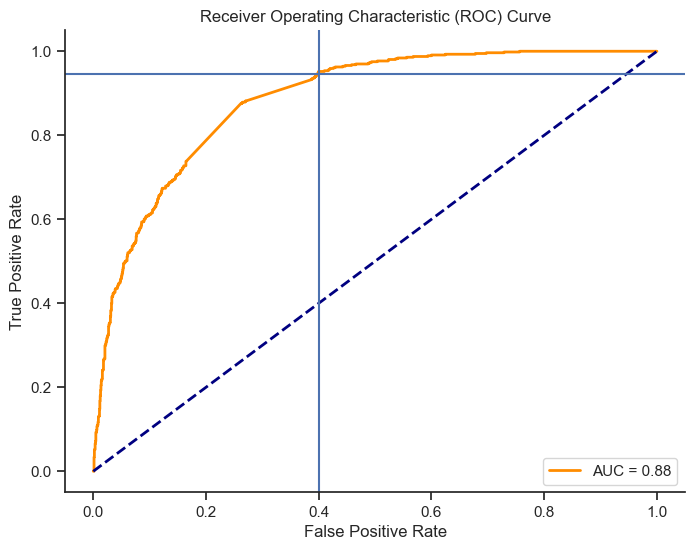

In [157]:
best_model = grid.best_estimator_
THRESHOLD = 0.4

# Predict probabilities on the test set
y_proba = best_model.predict_proba(X_test_tensor)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test_tensor, y_proba)

roc_auc = auc(fpr, tpr)
app_prob = tpr[np.where(np.isclose(THRESHOLD, fpr,rtol=1e-2))]
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.axhline(np.mean(app_prob))
plt.axvline(THRESHOLD)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

`ANN` model shows close results (0.2% diff) to `xgboost`, but `xgboost` still winning in tabular and filtered data

Fit a simple `DecisionTreeClassifier` model to obtain interpretability of desicions 

In [158]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.model_selection import GridSearchCV

model = DecisionTreeClassifier()

# Define parameter grid
param_grid = {
    'criterion': ['gini'],  # Split criterion
    'max_depth': [3,4,5],  # Maximum depth of the tree
    'min_samples_split': [1,2,3],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [3,4,5],  # Minimum number of samples required to be at a leaf node
}

# Create the GridSearchCV object
random_search_dt = GridSearchCV(
    model,
    param_grid,
    scoring= "roc_auc",  # Replace 'custom_scorer' with the metric you want to use
    cv=5,  # Adjust the number of folds for cross-validation
    n_jobs=-1,  # Use parallel processing if possible
)

# Fit the model to the data
random_search_dt.fit(X_train, y_train)

# Get the best model
best_model = random_search_dt.best_estimator_

# Predict on the test set
y_pred = best_model.predict(X_test)

# Evaluate the performance
# You can use your custom scoring metric or other metrics like accuracy, precision, recall, etc.
# For example: print(f'Accuracy: {accuracy_score(y_test, y_pred)}')

# Print the best hyperparameters
print("Best Hyperparameters:", random_search_dt.best_params_)

Best Hyperparameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 2}



45 fits failed out of a total of 135.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "d:\Repositories\ml-churn\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\Repositories\ml-churn\venv\Lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "d:\Repositories\ml-churn\venv\Lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "d:\Repositories\ml-churn\venv\Lib\site-packages\sklearn\utils\_param_validation.py", line 96, in validate_parameter_constraints
    

In [159]:
conf_matrix = confusion_matrix(y_test, y_pred)
print(calculate_metrics(conf_matrix))

{'Accuracy': 0.8234737340274492, 'Precision': 0.8012820512820513, 'Recall': 0.44563279857397503, 'Specificity': 0.9600515463917526, 'F1 Score': 0.572737686139748, 'False Positive Rate (FPR)': 0.03994845360824742, 'False Discovery Rate (FDR)': 0.1987179487179487, 'False Negative Rate (FNR)': 0.5543672014260249, 'Matthews Correlation Coefficient (MCC)': 0.5049883796402703}


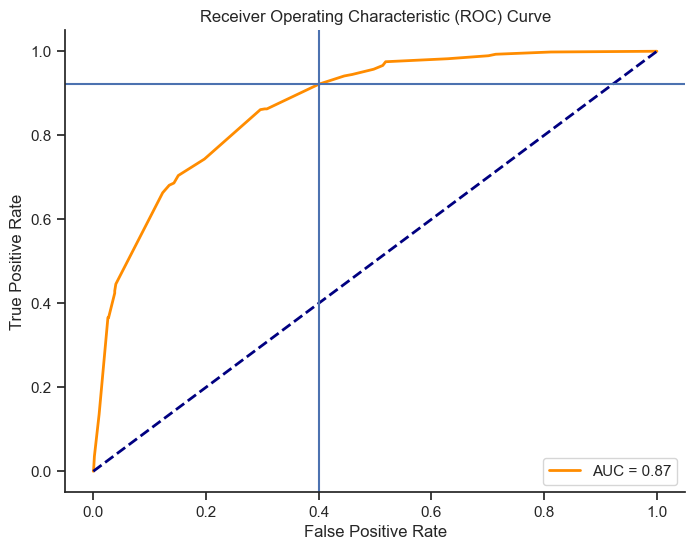

In [160]:
best_model = random_search_dt.best_estimator_
THRESHOLD = 0.4

# Predict probabilities on the test set
y_proba = best_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

roc_auc = auc(fpr, tpr)
app_prob = tpr[np.where(np.isclose(THRESHOLD, fpr,rtol=1e-2))]
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.axhline(np.mean(app_prob))
plt.axvline(THRESHOLD)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

A simple `DecisionTreeClassifier` **can do the work if accuracy its not a problem but interpretability is**,\
the difference between models is just 0.04%.

We render a plot of the desicion tree

In [161]:
import graphviz

model = DecisionTreeClassifier(criterion= "gini", max_depth= 5, min_samples_split= 2, min_samples_leaf=4)
model.fit(X_train,y_train)
X = Encoded_df
y = data_df.drop("Churn Value", axis=1)

dot_data = export_graphviz(
    model,
    out_file=None,
    feature_names=list(X.columns),
    class_names=[f'Class {i}' for i in set(y)],
    filled=True,
    rounded=True,
)

# Visualize the decision tree using Graphviz
graph = graphviz.Source(dot_data)
graph.render('decision_tree', format='png', cleanup=True)  # Save as PNG or other formats
graph.view('decision_tree')  # Open the visualization in the default viewer

'decision_tree.pdf'

Algorithm selection is up to the client, will he want explainability or accuracy?, as a first choice I propose the `xgboost` with `shap` values for explainability, merging the results from **EDA** and model explanation the most important variables coincide, so the model is doing a consistent work with high accuracy.

Build a voting classifier using different models in one pipeline

In [162]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from scipy.stats import uniform, randint, loguniform


from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from scipy.stats import uniform
from lightgbm import LGBMClassifier


In [163]:
X_train, X_test, y_train, y_test = train_test_split(X_data, data_df["Churn Value"],
                                                    test_size=0.2, random_state=42,
                                                    stratify=data_df["Churn Value"])

In [172]:
numerical_pipeline = Pipeline([
    ("Quantile_transformation", QuantileTransformer(output_distribution='normal')),
    # ("Std_transformation", joblib.load("research\std_transformer_all_data.pkl")),
    # ("PCA_transformation", PCA(10))
])
categorical_pipeline = Pipeline([
    ("One_hot_encoding", OneHotEncoder())
])


preprocessor = ColumnTransformer(transformers=[
    ("Numerical_pipe", numerical_pipeline, num_variable_usable),
    ("Cat_pipeline", categorical_pipeline, cat_variable_usable )
])


param_distributions = {
    # 'voting_clssifier__weights': [[1, 1, 1], [2, 1, 1], [1, 2, 1], [1, 1, 2]],  # Voting weights

    # XGBoost parameters
    'voting_clssifier__xgboost__learning_rate': loguniform(0.01, 0.1),
    'voting_clssifier__xgboost__n_estimators': randint(100, 1000),
    'voting_clssifier__xgboost__max_depth': randint(3, 10),
    'voting_clssifier__xgboost__subsample': uniform(0.5, 0.5),
    'voting_clssifier__xgboost__colsample_bytree': uniform(0.5, 0.5),
    'voting_clssifier__xgboost__gamma': loguniform(0.1, 1),
    'voting_clssifier__xgboost__reg_alpha': loguniform(1e-4, 1e4),
    'voting_clssifier__xgboost__reg_lambda': loguniform(1e-4, 1e4),

    # CatBoost parameters
    'voting_clssifier__catboost__learning_rate': loguniform(0.01, 0.1),
    'voting_clssifier__catboost__n_estimators': randint(100, 1000),
    'voting_clssifier__catboost__depth': randint(3, 10),
    'voting_clssifier__catboost__l2_leaf_reg': loguniform(0.1, 10),
    'voting_clssifier__catboost__subsample': uniform(0.5, 0.5),
    'voting_clssifier__catboost__colsample_bylevel': uniform(0.5, 0.5),
    'voting_clssifier__catboost__max_bin': randint(200, 500),

    # LightGBM parameters
    'voting_clssifier__lgbm__learning_rate': loguniform(0.01, 0.1),
    'voting_clssifier__lgbm__n_estimators': randint(100, 1000),
    'voting_clssifier__lgbm__num_leaves': randint(20, 40),
    'voting_clssifier__lgbm__max_depth': randint(3, 10),
    'voting_clssifier__lgbm__min_child_samples': randint(10, 30),
    'voting_clssifier__lgbm__subsample': uniform(0.5, 0.5),
    'voting_clssifier__lgbm__colsample_bytree': uniform(0.5, 0.5),
    'voting_clssifier__lgbm__reg_alpha': loguniform(1e-4, 1e4),
    'voting_clssifier__lgbm__reg_lambda': loguniform(1e-4, 1e4),

    
    'voting_clssifier__logistic_regression__C': loguniform(0.01, 10),

    # Add more parameters for other models if needed
}


models = [
    ('logistic_regression', LogisticRegression(verbose=False)),
    ('catboost', CatBoostClassifier(loss_function='Logloss', verbose=False)),
    ('xgboost', XGBClassifier(objective='binary:logistic')),
    ('lgbm', LGBMClassifier())
    # ('svm2', SVC(probability=True)),
    # ('svm1', SVC(probability=True))
]

voting_clf = VotingClassifier(models, voting='soft')

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('voting_clssifier', voting_clf)
])

random_search = RandomizedSearchCV(pipeline, param_distributions, n_iter=100, cv=5, scoring='roc_auc', random_state=42,
                                   verbose=False)



In [ ]:
random_search.fit(X_train, y_train)

In [174]:
fpr, tpr, thresholds = roc_curve(y_test, random_search.best_estimator_.predict_proba(X_test)[:, 1])
auc(fpr, tpr)

0.9169702136454055

In [175]:
random_search.best_score_

0.9122911081223748

In [176]:
joblib.dump(random_search.best_estimator_,"voting.pkl")


['voting.pkl']

In [178]:
results_rs = pd.DataFrame(random_search.cv_results_)

In [179]:
results_rs[results_rs["rank_test_score"] == 1]

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
27       5.262208      0.053548         0.052898        0.004778   

   param_voting_clssifier__catboost__colsample_bylevel  \
27                                           0.569414    

   param_voting_clssifier__catboost__depth  \
27                                       6   

   param_voting_clssifier__catboost__l2_leaf_reg  \
27                                      0.231079   

   param_voting_clssifier__catboost__learning_rate  \
27                                        0.022165   

   param_voting_clssifier__catboost__max_bin  \
27                                       394   

   param_voting_clssifier__catboost__n_estimators  ...  \
27                                            963  ...   

   param_voting_clssifier__xgboost__subsample  \
27                                   0.546145   

                                               params split0_test_score  \
27  {'voting_clssifier__catboost__colsample_byleve...          0.915128   

   split1_test_score split2_test_score split3_test_score split4_test_score  \
27          0.909202          0.912886          0.915641          0.908599   

   mean_test_score std_test_score rank_test_score  
27        0.912291       0.002926               1  

[1 rows x 38 columns]

Using a `VotingClassifier` we reach a mean `roc_auc` score of 91.2% with a 0.02% std which shows a more robust model than the previous `XGBoost` model with 90.8% mean `roc_auc` and 0.08% std.\
In both cases the `roc_auc` score is higher than 90% so `XGBoost` model is selected for simplicity and speed in fitting.